# Two Step Forecasting for weather and kWh delivered using GRU

In this model, I would be implementing a two-step forecast that would first predict the weather for a time in the future and then use the predicted weather data as an input for the kWh Delivered forecasting for the model.

In summary, I will be exploring three methods:

1. Using historical weather data from only one charging station to predict kWhDelivered
2. Using historical weather data from 54 charging stations with cummulative kWhDelivered added based on stationID
3. Using historical data for each 54 charging stations using Transfer Learning

# First step Forecasting

Predicting future weather data and testing the accuracy of the GRU model

In [1]:
# Import necessary packages

In [1]:
import os
import json
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from smape import smape
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, load_model
from keras.layers import GRU, Input, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *

# Make the process reproducible using a seed
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.config.experimental.enable_op_determinism()

# Limit TensorFlow to a single thread
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["TF_NUM_INTRAOP_THREADS"] = "1"
os.environ["TF_NUM_INTEROP_THREADS"] = "1"

In [11]:
# Load the weather data from the weather data folder

In [3]:
folder_path = './jpl_weather_data'
data_frames = []

# Function to safely extract data from JSON
def extract_hourly_data(data):
    historical_data = data.get('historical', {})
    for date, details in historical_data.items():
        hourly_data = details.get('hourly', [])
        for hour_data in hourly_data:
            hour_data['date'] = date
            data_frames.append(hour_data)

for file_name in os.listdir(folder_path):
    if file_name.endswith('.json'):
        file_path = os.path.join(folder_path, file_name)
        try:
            with open(file_path) as file:
                data = json.load(file)
                extract_hourly_data(data)
        except (json.JSONDecodeError, KeyError) as e:
            print(f"Error processing file {file_name}: {e}")

df = pd.DataFrame(data_frames)
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)


weather_df = pd.DataFrame(data_frames)
weather_df['date'] = pd.to_datetime(weather_df['date'])
weather_df.sort_values('date', inplace=True)

# Select relevant features
weather_features = ['temperature', 'wind_speed', 'pressure', 'humidity', 'precip']
weather_df = weather_df[weather_features + ['date']]

# Aggregate weather data by day (since kWh data is monthly, daily aggregation should be sufficient)
weather_daily_df = weather_df.groupby('date').mean().reset_index()

In [13]:
# Select relevant features

In [4]:
features = ['temperature', 'wind_speed', 'pressure', 'humidity', 'precip']
df = df[features + ['date']]

In [ ]:
# Normalize the data and split into training and testing sets

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[features])

# Create sequences for GRU
sequence_length = 30
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i])

X, y = np.array(X), np.array(y)

# Split data into training and testing sets
train_size = int(X.shape[0] * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
scaled_data

array([[0.62790698, 0.4375    , 0.28125   , 0.44680851, 0.        ],
       [0.65116279, 0.40625   , 0.34375   , 0.41489362, 0.        ],
       [0.58139535, 0.15625   , 0.375     , 0.43617021, 0.        ],
       ...,
       [0.58139535, 0.46875   , 0.40625   , 0.30851064, 0.        ],
       [0.53488372, 0.375     , 0.40625   , 0.37234043, 0.        ],
       [0.41860465, 0.1875    , 0.4375    , 0.60638298, 0.        ]])

In [46]:
# Build a GRU using the data from the model

In [6]:
input_shape= (X_train.shape[1], X_train.shape[2])
model = Sequential()
model.add(Input(shape=input_shape))
model.add(GRU(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=len(features)))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0200
Epoch 2/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0103
Epoch 3/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0093
Epoch 4/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0090
Epoch 5/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0085
Epoch 6/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0084
Epoch 7/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0082
Epoch 8/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0080
Epoch 9/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0080
Epoch 10/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0079
Epoch 11/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0078
Epoch 12/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0077
Epoch 13/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0076
Epoch 14/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0075
Epoch 15/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 7s

In [17]:
# Evaluate the model and check for accuracy

In [7]:
# Make predictions
y_pred = model.predict(X_test)

# Inverse scale the predictions and actual values
y_test_inverse = scaler.inverse_transform(y_test)
y_pred_inverse = scaler.inverse_transform(y_pred)

# Evaluate the model for each feature
mae_per_feature = []
mse_per_feature = []

for i, feature in enumerate(features):
    mae = mean_absolute_error(y_test_inverse[:, i], y_pred_inverse[:, i])
    mse = mean_squared_error(y_test_inverse[:, i], y_pred_inverse[:, i])
    mae_per_feature.append(mae)
    mse_per_feature.append(mse)
    print(f'{feature.capitalize()} - Mean Absolute Error: {mae}')
    print(f'{feature.capitalize()} - Mean Squared Error: {mse}')


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Temperature - Mean Absolute Error: 2.0715306427909566
Temperature - Mean Squared Error: 7.151439931703677
Wind_speed - Mean Absolute Error: 2.9000624289595094
Wind_speed - Mean Squared Error: 14.100970329497512
Pressure - Mean Absolute Error: 1.2639932831483862
Pressure - Mean Squared Error: 3.0786267095309285
Humidity - Mean Absolute Error: 8.611649655414324
Humidity - Mean Squared Error: 126.95110541021057
Precip - Mean Absolute Error: 0.1490009113043411
Precip - Mean Squared Error: 0.22083332016199314


In [ ]:
#Plot the results

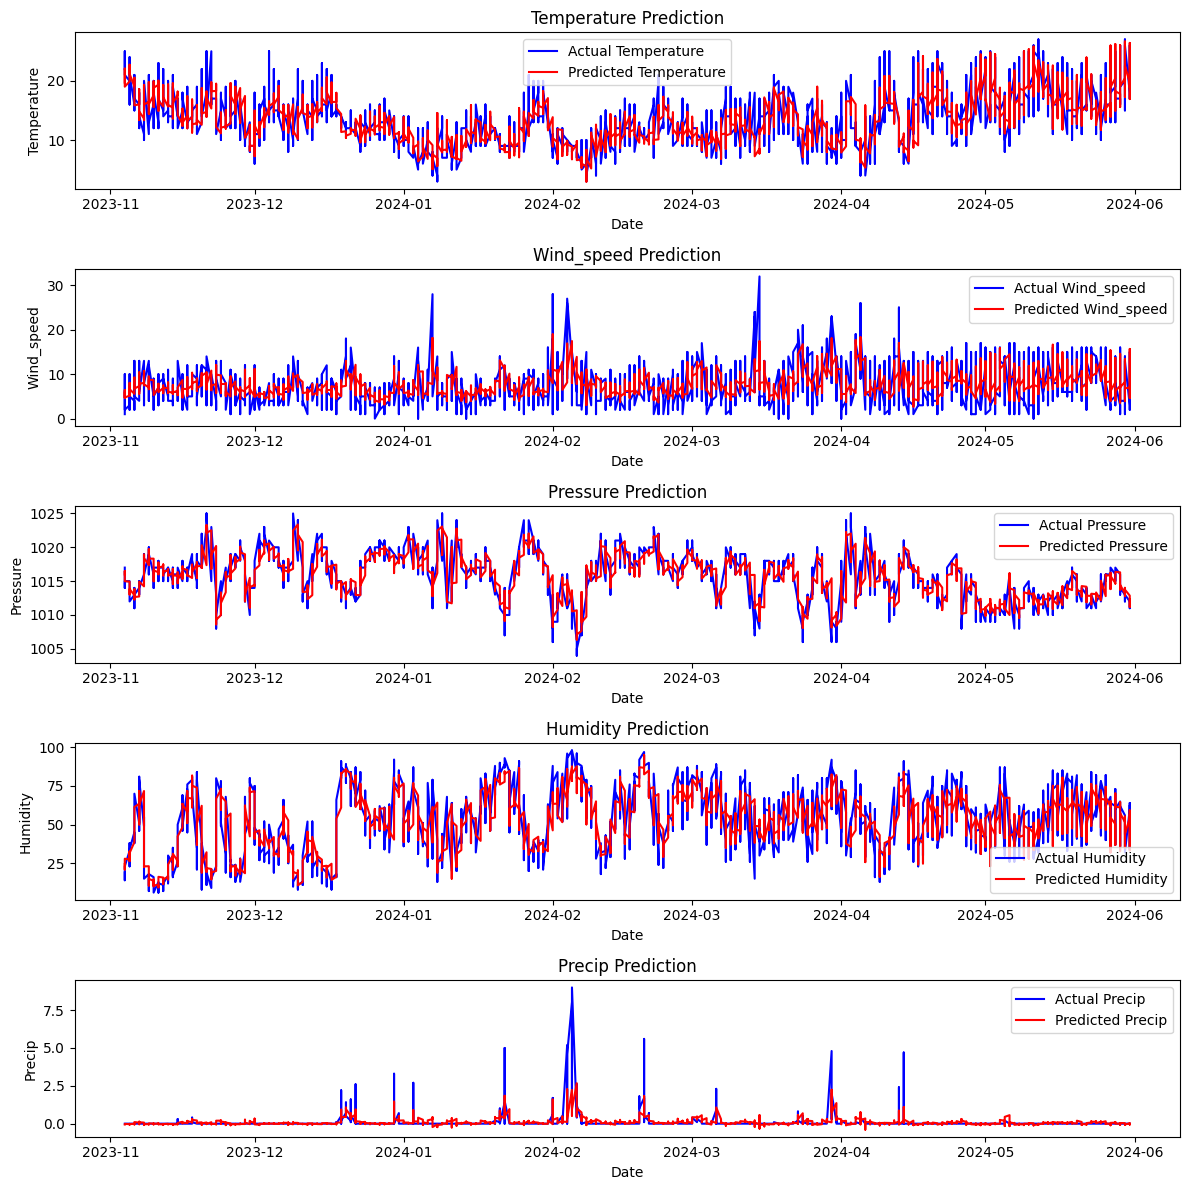

In [8]:
# Plot Actual vs Predicted for all features
plt.figure(figsize=(12, 12))
for i, feature in enumerate(features):
    plt.subplot(len(features), 1, i+1)
    plt.plot(df['date'][train_size+sequence_length:], y_test_inverse[:, i], color='blue', label=f'Actual {feature.capitalize()}')
    plt.plot(df['date'][train_size+sequence_length:], y_pred_inverse[:, i], color='red', label=f'Predicted {feature.capitalize()}')
    plt.title(f'{feature.capitalize()} Prediction')
    plt.xlabel('Date')
    plt.ylabel(feature.capitalize())
    plt.legend()

plt.tight_layout()
plt.show()

# Second step

Using the forecasted weather data to predict future kWh delivered by electric vehicle charging stations

## Method 1: Using historical weather data from only one charging station to predict kWhDelivered

In [26]:
# Load the model data for single charging station
data = pd.read_csv('./jpl_model_data/1-1-178-817.csv')
data.head()

month  siteID    stationID             timezone  spaceID  kWhDelivered  \
0  2018-09       1  1-1-178-817  America/Los_Angeles  AG-1F09    197.982000   
1  2018-10       1  1-1-178-817  America/Los_Angeles  AG-1F09    470.523645   
2  2018-11       1  1-1-178-817  America/Los_Angeles  AG-1F09    373.943000   
3  2018-12       1  1-1-178-817  America/Los_Angeles  AG-1F09    290.616000   
4  2019-01       1  1-1-178-817  America/Los_Angeles  AG-1F09    408.382000   

   MinTemp  MaxTemp    AvgTemp  AvgPrecipitation  AvgHumidity  AvgWindSpeed  
0       17       35  24.533333          0.000000    49.204167      7.287500  
1       14       32  21.064516          0.021371    47.125000      6.241935  
2       11       32  17.733333          0.058333    38.812500      6.316667  
3        5       25  13.225806          0.067339    44.790323      5.927419  
4        3       25  12.838710          0.232258    50.447581      6.814516

In [27]:
# Convert the month to datetime format and set it as the index
data['Month'] = pd.to_datetime(data['month'])
data.set_index('Month', inplace=True)

In [28]:
# Select the features (weather data) and target variable (kWhDelivered)
features = ['MinTemp', 'MaxTemp', 'AvgTemp', 'AvgPrecipitation', 'AvgHumidity', 'AvgWindSpeed']
target = 'kWhDelivered'

# Scale the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(data[features])

# Scale the target variable (kWhDelivered) separately
target_scaler = MinMaxScaler()
scaled_target = target_scaler.fit_transform(data[[target]])  # Use double brackets to keep it as a DataFrame
data['Scaled_kWhDelivered'] = scaled_target

In [29]:
# Convert the scaled features back to a DataFrame
scaled_features_df = pd.DataFrame(scaled_features, columns=features, index=data.index)

# Combine the scaled features with the scaled target variable
scaled_data = pd.concat([scaled_features_df, data['Scaled_kWhDelivered']], axis=1)

# Create a lagged feature for kWhDelivered
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i+sequence_length][features].values
        label = data.iloc[i+sequence_length]['Scaled_kWhDelivered']
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

# Set the sequence length (e.g., 1 for 1 months of data)
sequence_length = 1

# Create sequences and targets
X, y = create_sequences(scaled_data, sequence_length)

In [30]:
# Split the data into training and testing sets (use all except the last one for training)
X_train, X_test = X[:-1], X[-1:]
y_train, y_test = y[:-1], y[-1:]

# Extract the months corresponding to the training and test data
months_train = data.index[sequence_length:len(X_train)+sequence_length]
months_test = data.index[-len(X_test):]

# Define the GRU model
input_shape = (X_train.shape[1], X_train.shape[2])
model = Sequential()
model.add(Input(shape=input_shape))
model.add(GRU(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.4653
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4808
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4205
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3990
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3627
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3341
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3320
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.2782
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2478
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2392
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2275
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2138
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1662
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1460
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1396
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


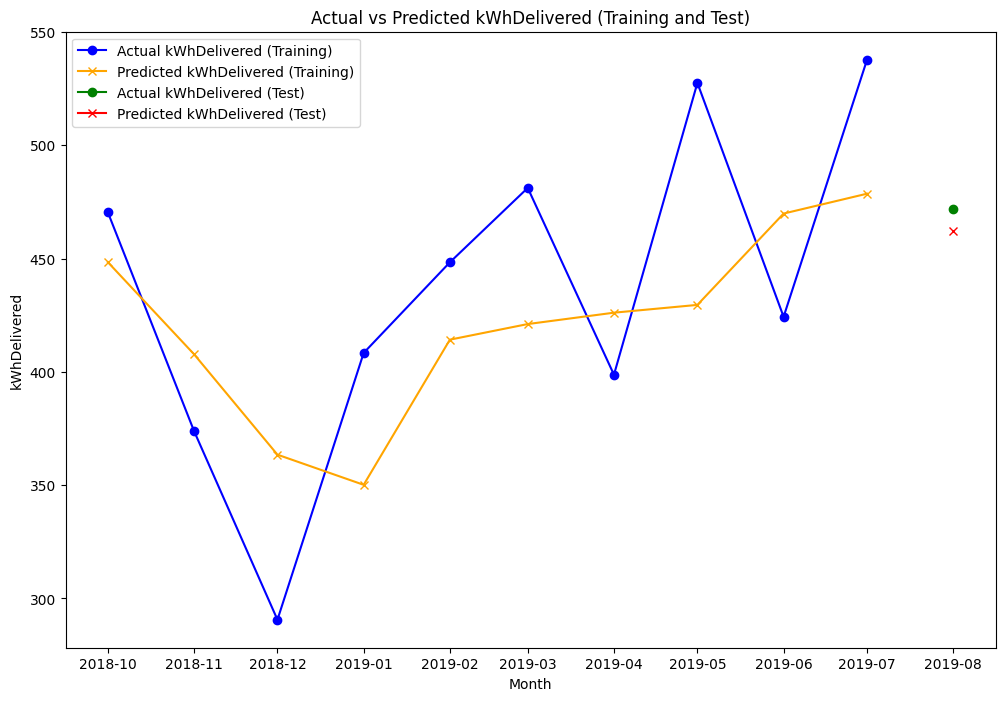

In [31]:
# Predict the values for both training and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Reshape y_train, y_test, y_train_pred, and y_test_pred for inverse transformation
y_train_scaled = y_train.reshape(-1, 1)
y_test_scaled = y_test.reshape(-1, 1)
y_train_pred_scaled = y_train_pred.reshape(-1, 1)
y_test_pred_scaled = y_test_pred.reshape(-1, 1)

# Inverse transform the predictions and actual values using the target scaler
y_train_inversed = target_scaler.inverse_transform(y_train_scaled)
y_test_inversed = target_scaler.inverse_transform(y_test_scaled)
y_train_pred_inversed = target_scaler.inverse_transform(y_train_pred_scaled)
y_test_pred_inversed = target_scaler.inverse_transform(y_test_pred_scaled)

# Plot the actual vs predicted values against the month for both training and test sets
plt.figure(figsize=(12, 8))

# Plot training data
plt.plot(months_train, y_train_inversed, label='Actual kWhDelivered (Training)', marker='o', color='blue')
plt.plot(months_train, y_train_pred_inversed, label='Predicted kWhDelivered (Training)', marker='x', color='orange')

# Plot test data
plt.plot(months_test, y_test_inversed, label='Actual kWhDelivered (Test)', marker='o', color='green')
plt.plot(months_test, y_test_pred_inversed, label='Predicted kWhDelivered (Test)', marker='x', color='red')

plt.title('Actual vs Predicted kWhDelivered (Training and Test)')
plt.xlabel('Month')
plt.ylabel('kWhDelivered')
plt.legend()
plt.show()

In [14]:
# Define the metrics
mse = mean_squared_error(y_test_inversed, y_test_pred_inversed)
mae = mean_absolute_error(y_test_inversed, y_test_pred_inversed)
smape_value = smape(y_test_inversed, y_test_pred_inversed)

print(f'Mean Squared Error: {round(mse,2)}')
print(f'Mean Absolute Error: {round(mae,2)}')
print(f'Symmetric Mean Absolute Percentage Error: {round(smape_value,2)}%')

Mean Squared Error: 4689.73
Mean Absolute Error: 68.48
Symmetric Mean Absolute Percentage Error: 26.98%


## Method 2: Making Predictions with GRU using historical weather data from 54 charging stations with cummulative kWhDelivered

In [74]:
directory = './jpl_model_data'

In [75]:
combined_data = pd.DataFrame()


# Loop through each CSV file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        filepath = os.path.join(directory, filename)
        # Load the data from the CSV file
        data = pd.read_csv(filepath)
        # Append the data to the combined DataFrame
        combined_data = pd.concat([combined_data, data], axis=0)

summed_data = combined_data.groupby('month').agg({
    'kWhDelivered': 'sum',
    'MinTemp': 'first',
    'MaxTemp': 'first',
    'AvgTemp': 'first',
    'AvgPrecipitation': 'first',
    'AvgHumidity': 'first',
    'AvgWindSpeed': 'first'
}).reset_index()

# Print or save the result
summed_data.head()

month  kWhDelivered  MinTemp  MaxTemp    AvgTemp  AvgPrecipitation  \
0  2018-09   9514.851000       17       35  24.533333          0.000000   
1  2018-10  18161.496291       14       32  21.064516          0.021371   
2  2018-11  15311.232726       11       32  17.733333          0.058333   
3  2018-12  14177.875000        5       25  13.225806          0.067339   
4  2019-01  19698.515000        3       25  12.838710          0.232258   

   AvgHumidity  AvgWindSpeed  
0    49.204167      7.287500  
1    47.125000      6.241935  
2    38.812500      6.316667  
3    44.790323      5.927419  
4    50.447581      6.814516

In [76]:
# Convert the month to datetime format and set it as the index
summed_data['Month'] = pd.to_datetime(summed_data['month'])
summed_data.set_index('Month', inplace=True)

In [77]:
# Select the features (weather data) and target variable (kWhDelivered)
features = ['MinTemp', 'MaxTemp', 'AvgTemp', 'AvgPrecipitation', 'AvgHumidity', 'AvgWindSpeed']
target = 'kWhDelivered'

# Scale the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(summed_data[features])

# Scale the target variable (kWhDelivered) separately
target_scaler = MinMaxScaler()
scaled_target = target_scaler.fit_transform(summed_data[[target]])  # Use double brackets to keep it as a DataFrame
summed_data['Scaled_kWhDelivered'] = scaled_target

In [78]:
# Convert the scaled features back to a DataFrame
scaled_features_df = pd.DataFrame(scaled_features, columns=features, index=summed_data.index)

# Combine the scaled features with the scaled target variable
scaled_data = pd.concat([scaled_features_df, summed_data['Scaled_kWhDelivered']], axis=1)

# Create a lagged feature for kWhDelivered
def create_sequences(summed_data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(summed_data) - sequence_length):
        seq = summed_data.iloc[i:i+sequence_length][features].values
        label = summed_data.iloc[i+sequence_length]['Scaled_kWhDelivered']
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

# Set the sequence length (e.g., 3 for 3 months of data)
sequence_length = 3

# Create sequences and targets
X, y = create_sequences(scaled_data, sequence_length)

In [79]:
# Split the data into training and testing sets (use all except the last one for training)
X_train, X_test = X[:-1], X[-1:]
y_train, y_test = y[:-1], y[-1:]

# Extract the months corresponding to the training and test data
months_train = summed_data.index[sequence_length:len(X_train)+sequence_length]
months_test = summed_data.index[-len(X_test):]

# Define the GRU model
input_shape = (X_train.shape[1], X_train.shape[2])
model = Sequential()
model.add(Input(shape=input_shape))
model.add(GRU(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.7284
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6517
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5874
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.5222
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4200
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3654
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2765
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2347
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1899
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1562
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0903
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1029
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0891
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0640
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1089
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


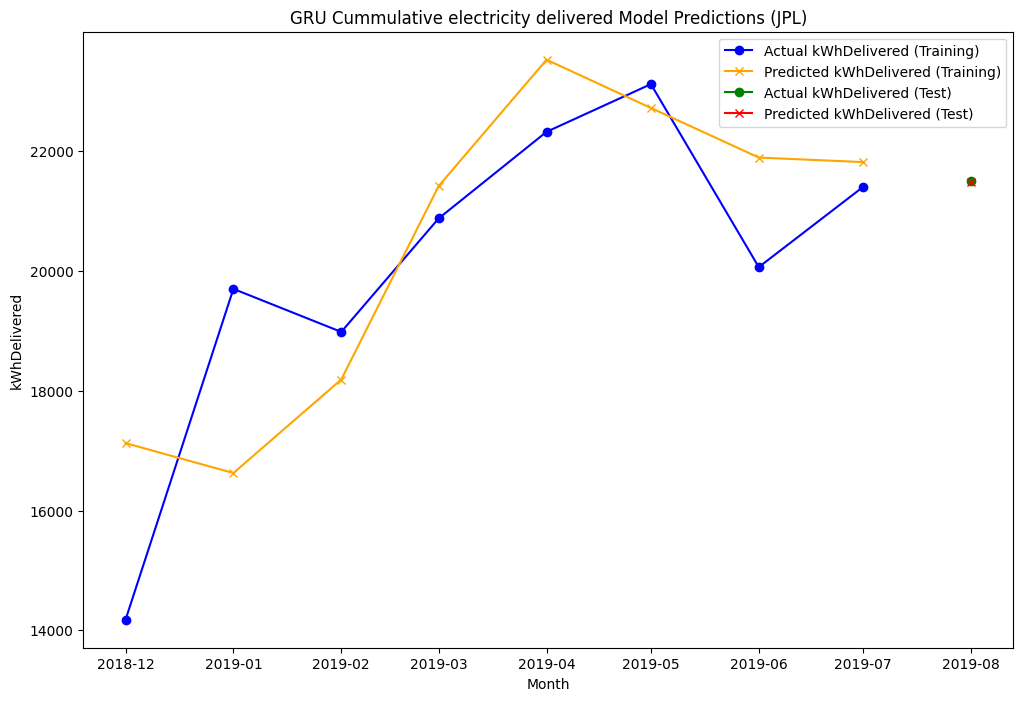

In [82]:
# Predict the values for both training and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Reshape y_train, y_test, y_train_pred, and y_test_pred for inverse transformation
y_train_scaled = y_train.reshape(-1, 1)
y_test_scaled = y_test.reshape(-1, 1)
y_train_pred_scaled = y_train_pred.reshape(-1, 1)
y_test_pred_scaled = y_test_pred.reshape(-1, 1)

# Inverse transform the predictions and actual values using the target scaler
y_train_inversed = target_scaler.inverse_transform(y_train_scaled)
y_test_inversed = target_scaler.inverse_transform(y_test_scaled)
y_train_pred_inversed = target_scaler.inverse_transform(y_train_pred_scaled)
y_test_pred_inversed = target_scaler.inverse_transform(y_test_pred_scaled)

# Plot the actual vs predicted values against the month for both training and test sets
plt.figure(figsize=(12, 8))

# Plot training data
plt.plot(months_train, y_train_inversed, label='Actual kWhDelivered (Training)', marker='o', color='blue')
plt.plot(months_train, y_train_pred_inversed, label='Predicted kWhDelivered (Training)', marker='x', color='orange')

# Plot test data
plt.plot(months_test, y_test_inversed, label='Actual kWhDelivered (Test)', marker='o', color='green')
plt.plot(months_test, y_test_pred_inversed, label='Predicted kWhDelivered (Test)', marker='x', color='red')

plt.title('GRU Cummulative electricity delivered Model Predictions (JPL)')
plt.xlabel('Month')
plt.ylabel('kWhDelivered')
plt.legend()
plt.show()

In [83]:
# Define the metrics
mse = mean_squared_error(y_test_inversed, y_test_pred_inversed)
mae = mean_absolute_error(y_test_inversed, y_test_pred_inversed)
smape_value = smape(y_test_inversed, y_test_pred_inversed)

print(f'Mean Squared Error: {round(mse,2)}')
print(f'Mean Absolute Error: {round(mae,2)}')
print(f'Symmetric Mean Absolute Percentage Error: {round(smape_value,2)}%')

Mean Squared Error: 294.4
Mean Absolute Error: 17.16
Symmetric Mean Absolute Percentage Error: 0.08%


## Method 3: Making Predictions with GRU using historical weather data for each 54 charging stations with Transfer Learning

### With Transfer Learning

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.5913
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5676
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5643
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5616
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5762
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5227
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5597
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5593
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5334
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5326
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5505
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5410
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5286
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5245
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5071
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

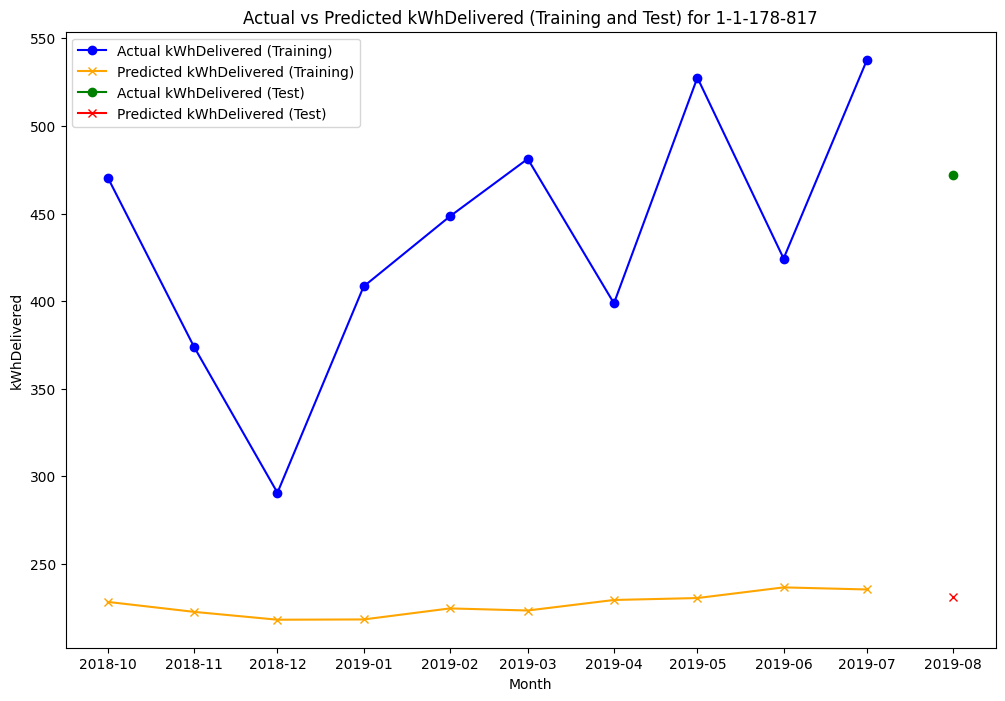

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1773
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1779
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1665
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1687
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1751
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1635
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1639
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1758
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1705
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1478
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1565
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1519
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1563
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1572
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1546
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

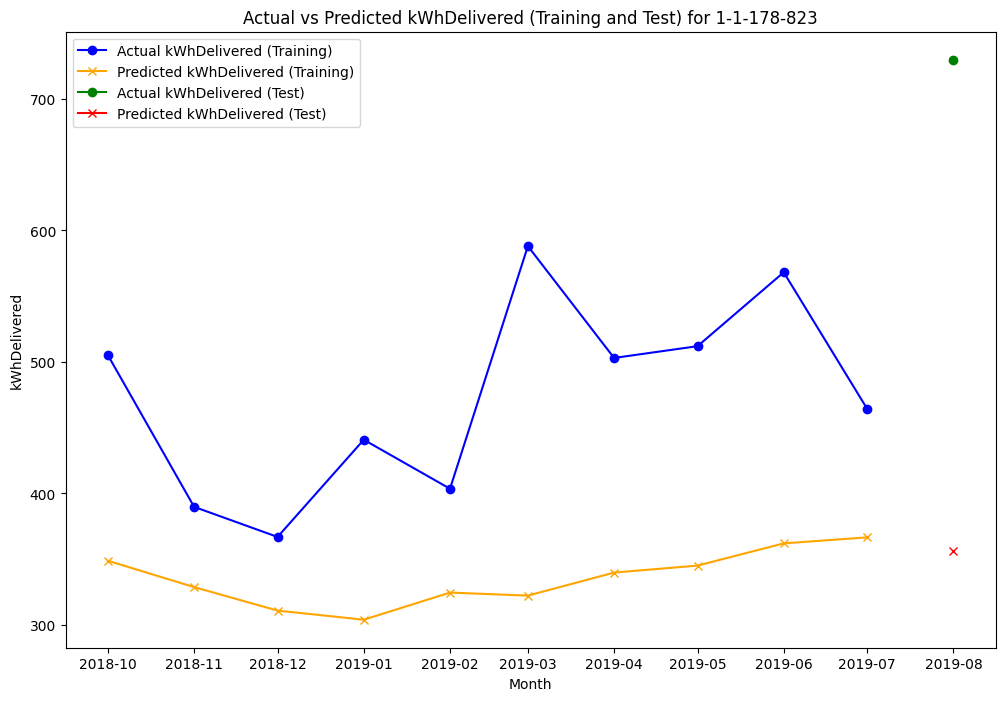

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2052
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1912
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1816
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1863
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1825
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1842
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1767
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1751
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1756
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1870
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1750
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1666
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1590
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1716
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1734
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

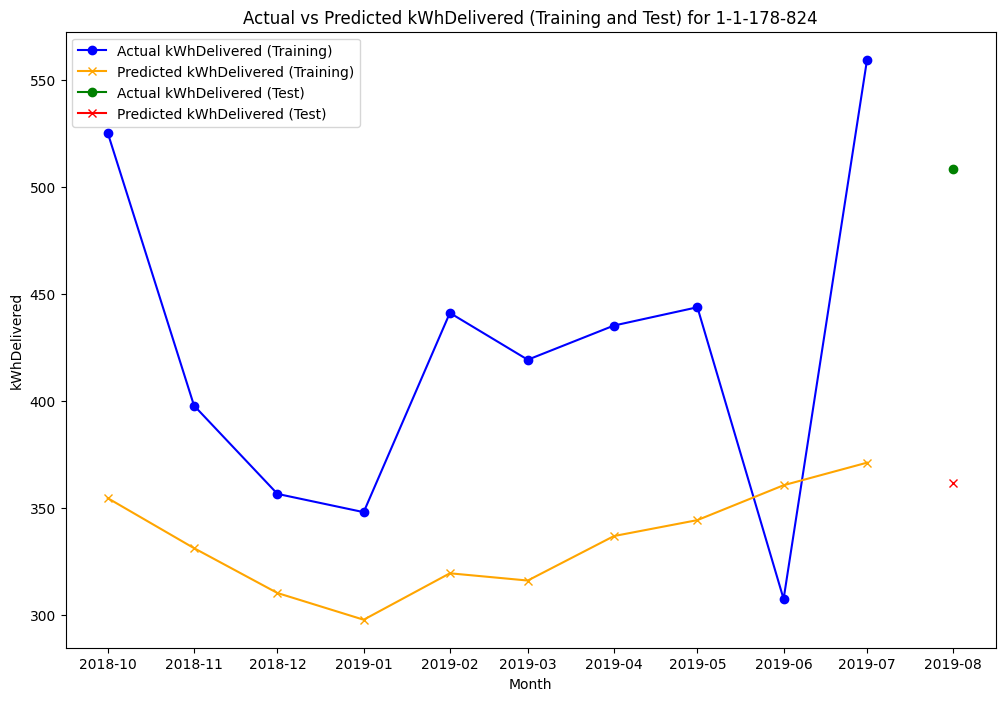

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1268
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1342
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1228
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1506
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1293
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1384
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1381
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1289
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1298
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1206
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1131
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1073
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1005
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1040
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1039
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

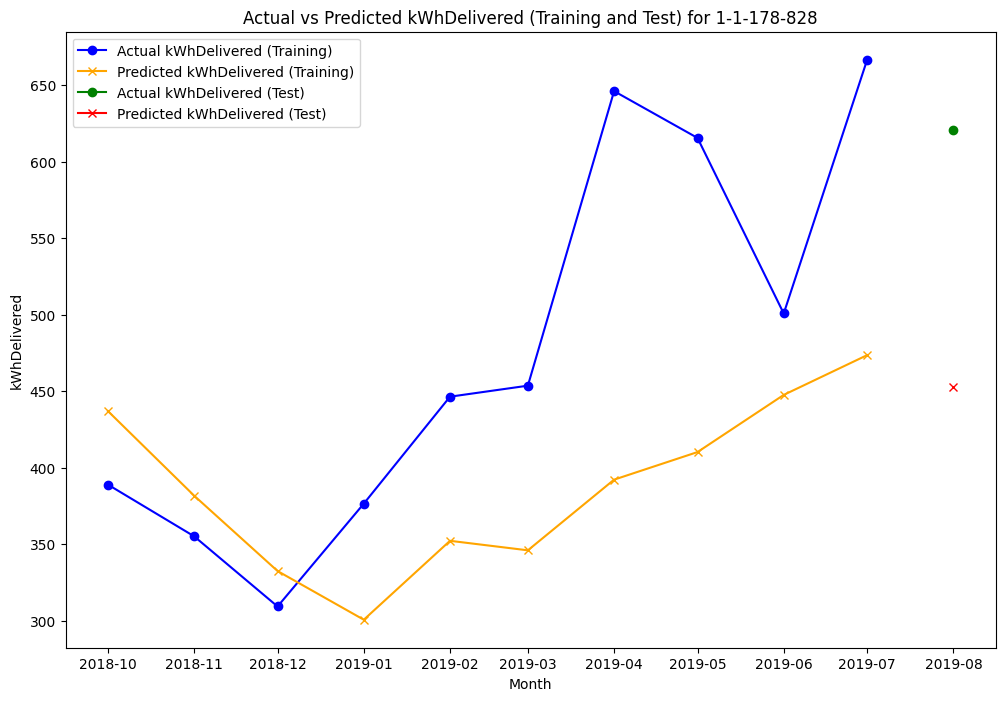

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0851
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0523
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0641
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0712
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0722
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0629
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0677
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0748
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0552
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0663
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0612
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0628
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0562
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0545
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0675
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

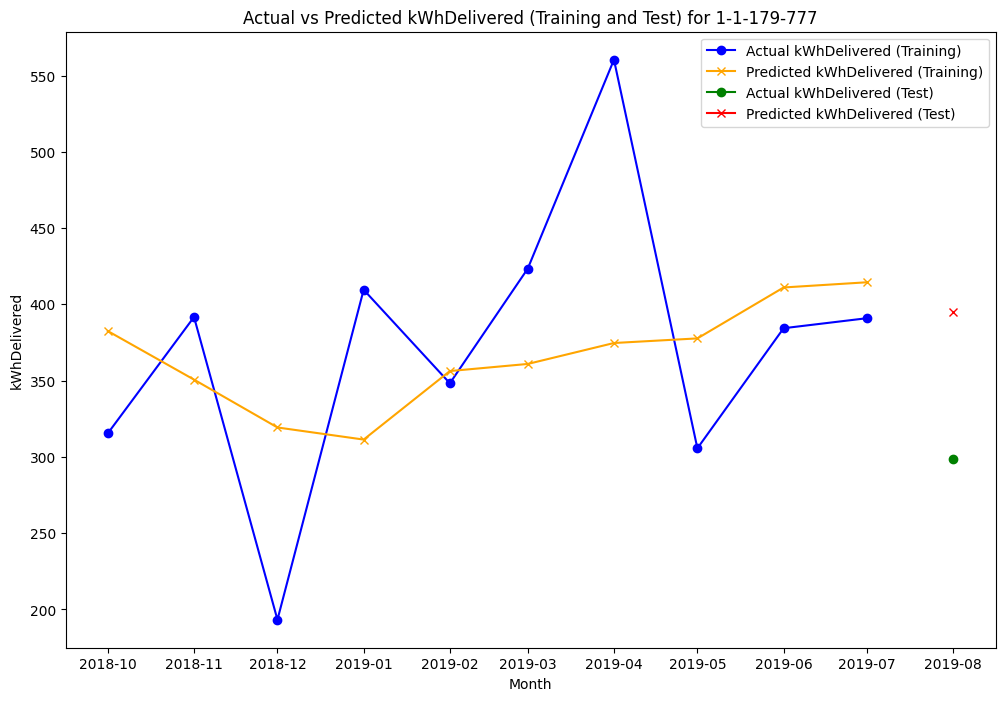

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.0735
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0719
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0830
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0872
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0779
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0708
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0763
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0894
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0794
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0648
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0652
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0676
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0711
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0799
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0708
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

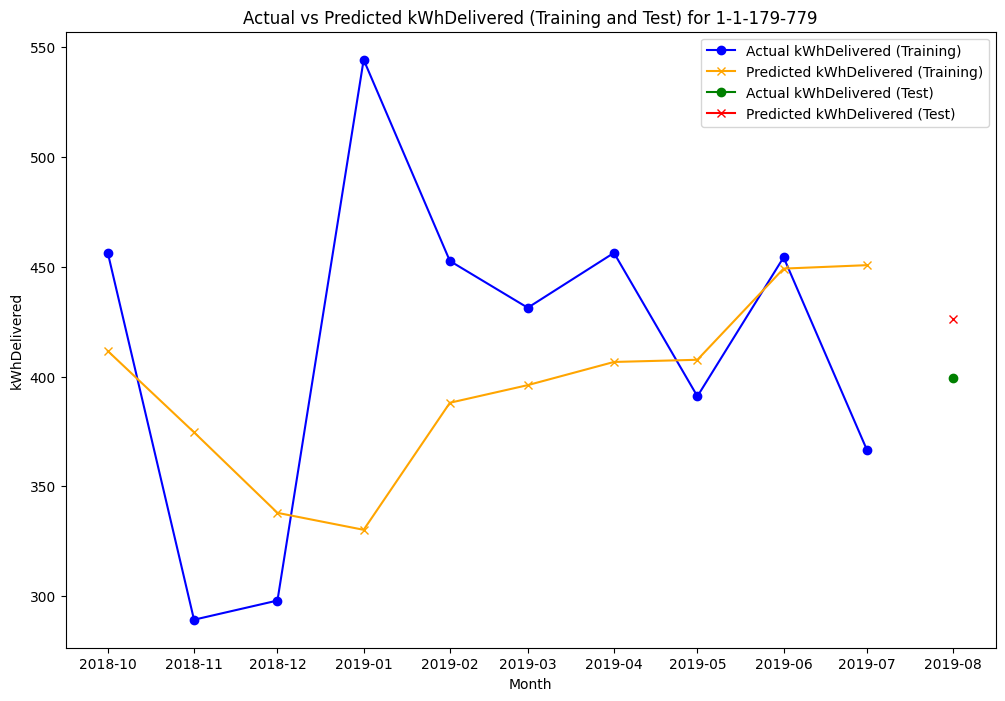

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0633
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0392
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0554
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0559
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0634
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0413
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0506
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0410
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0520
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0479
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0499
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0418
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0532
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0502
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0491
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

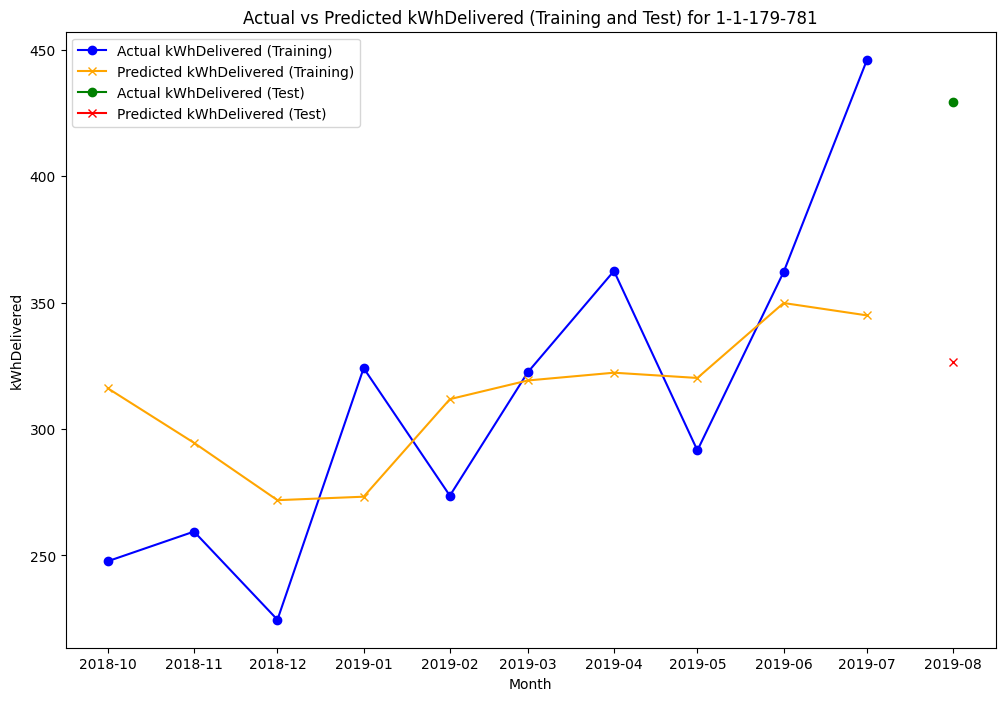

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0652
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0857
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0725
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0690
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0804
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0649
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0534
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0512
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0674
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0726
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0772
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0640
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0827
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0752
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0708
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

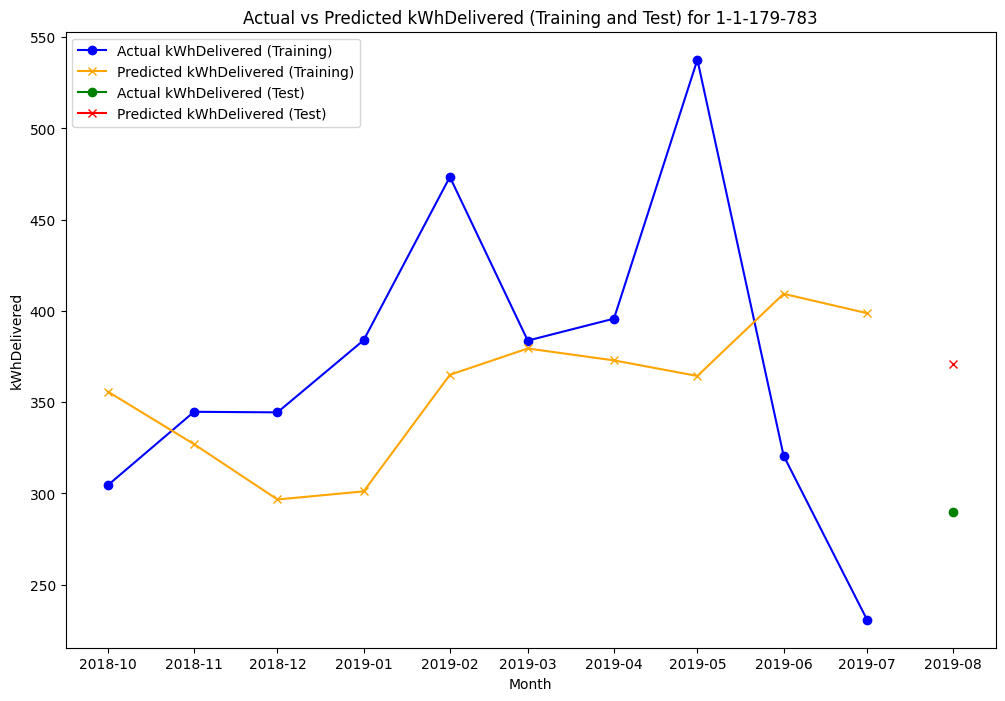

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0775
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0676
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0943
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0727
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0755
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0796
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1056
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1026
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0583
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0769
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0723
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0717
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0908
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0742
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0716
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

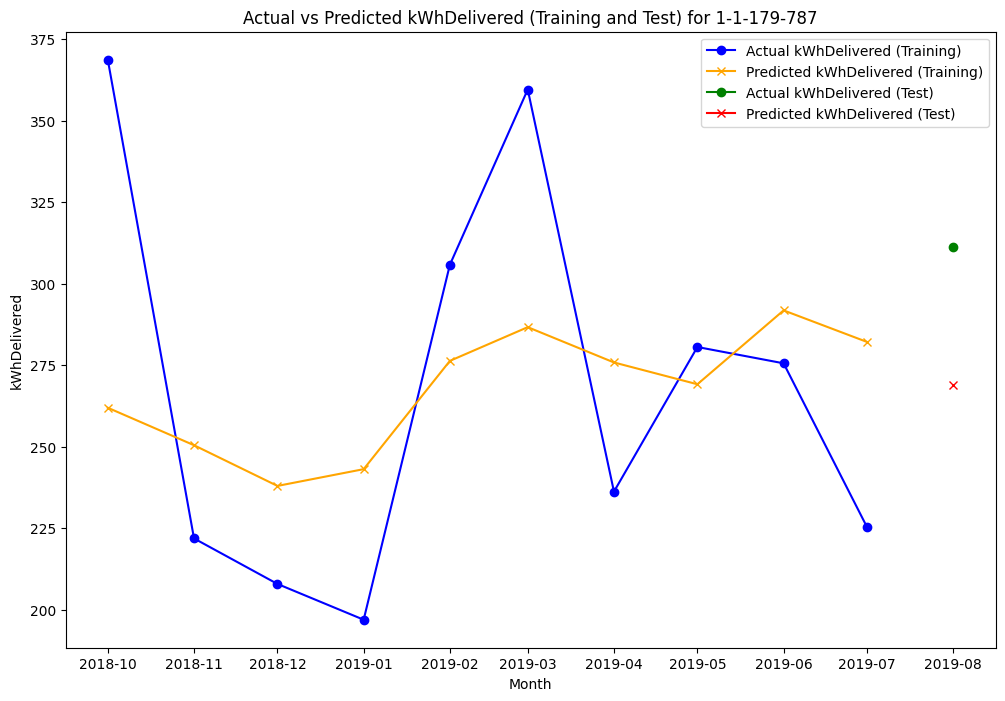

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0563
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0433
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0431
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0424
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0458
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0439
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0428
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0400
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0606
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0427
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0414
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0498
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0515
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0396
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0491
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

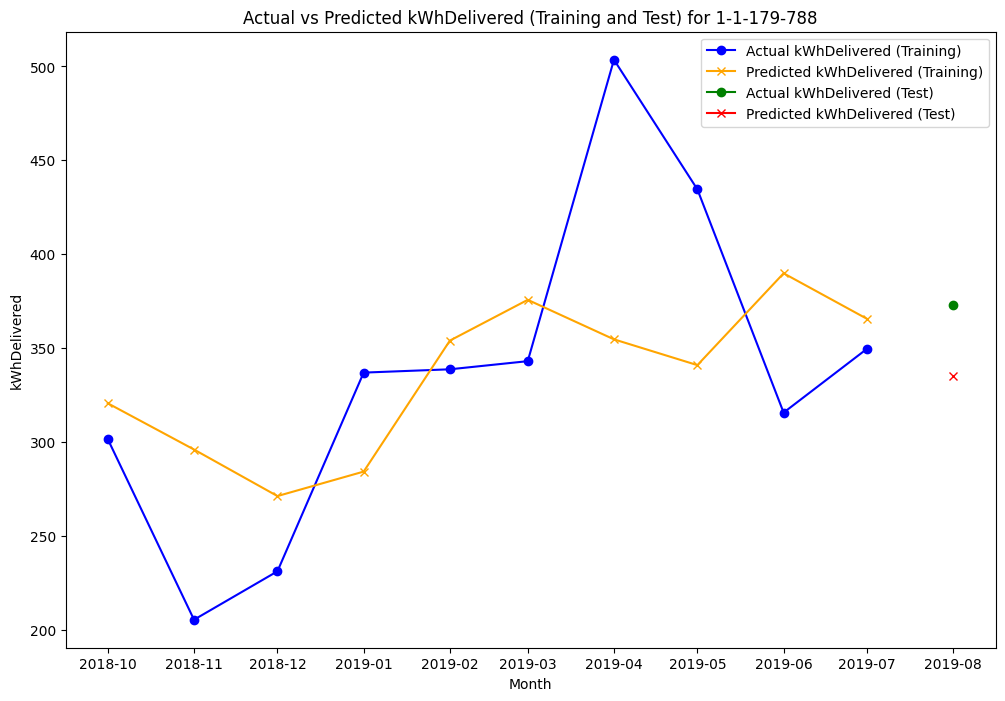

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0745
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0835
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0695
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0605
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0726
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0690
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0836
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0501
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0587
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0544
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0462
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0515
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0776
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0754
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0637
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

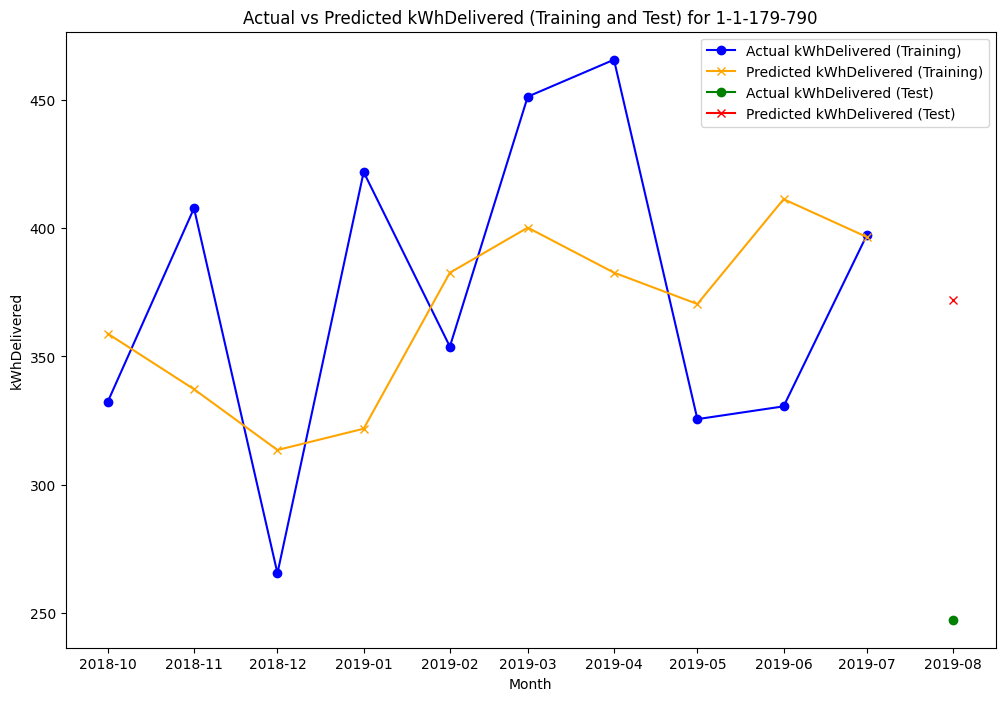

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1397
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1490
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1382
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1328
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1291
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1607
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1052
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1365
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1148
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1575
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1343
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1284
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1194
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1231
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1077
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

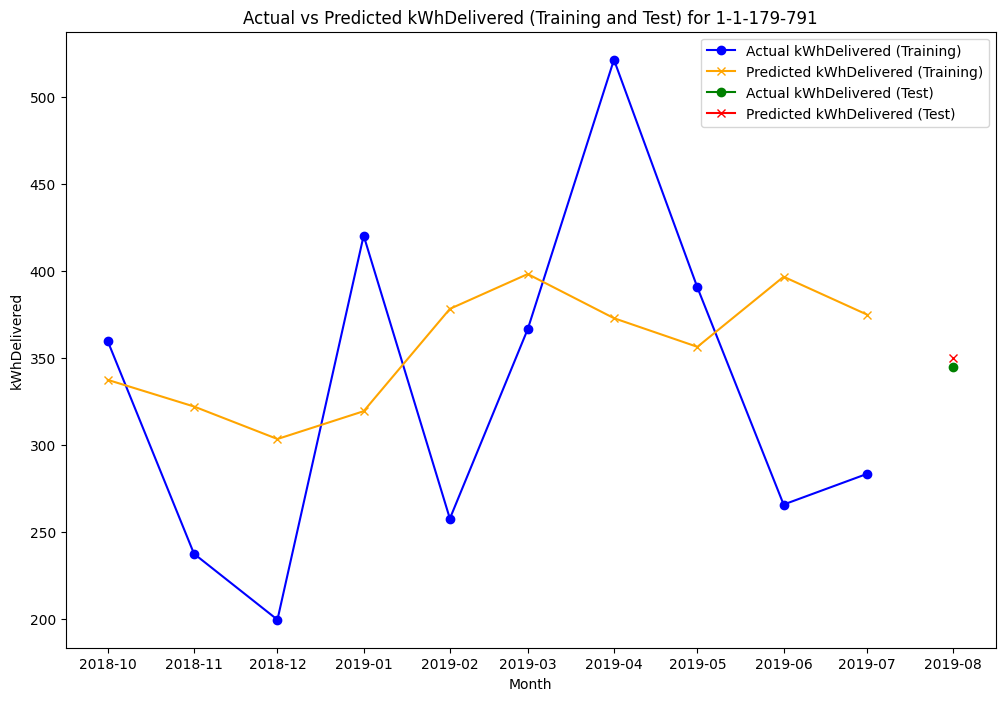

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0957
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0696
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1046
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0836
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0786
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0927
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0871
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0740
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0922
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0974
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0771
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0933
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0859
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0974
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0960
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

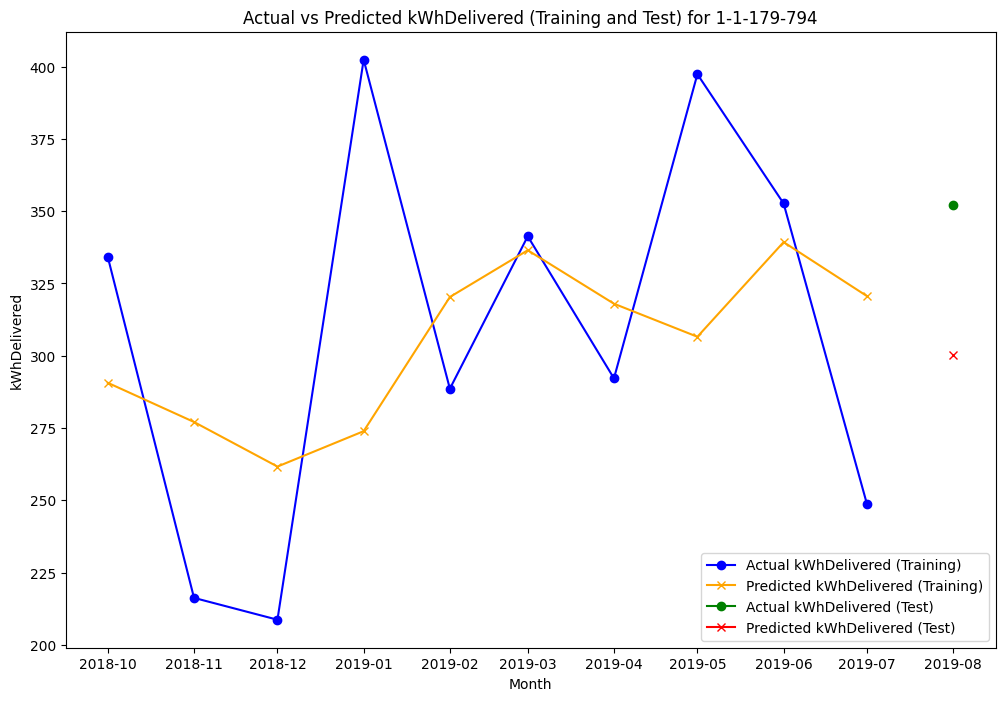

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0303
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0371
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0437
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0425
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0493
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0285
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0350
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0336
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0318
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0488
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0278
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0337
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0354
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0337
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0327
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

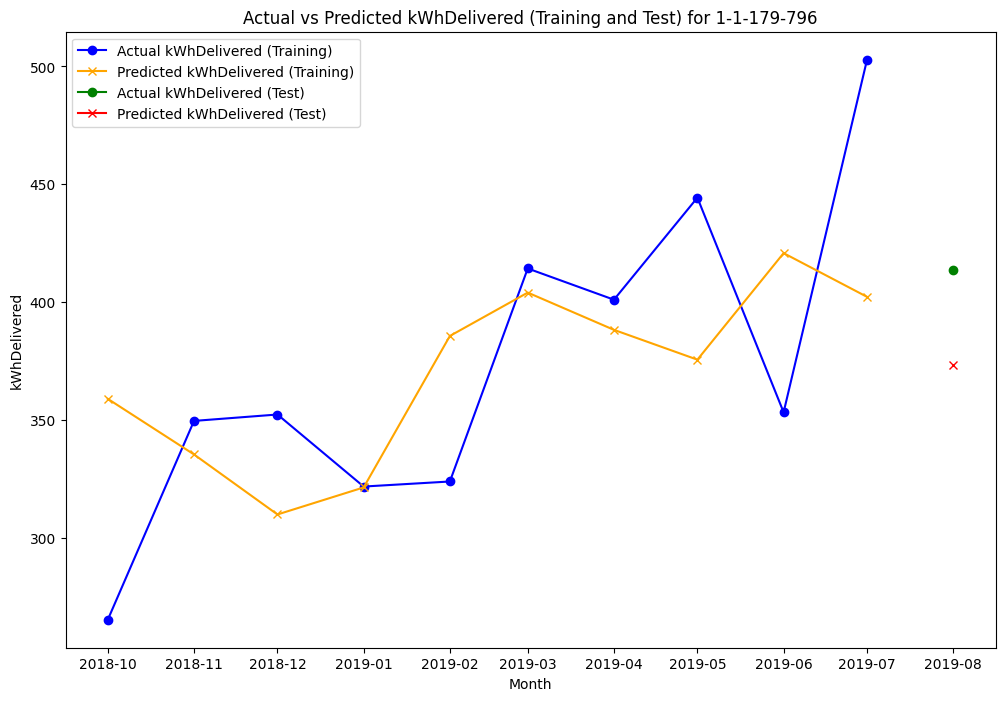

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0930
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0927
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0775
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0735
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0815
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0786
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0881
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0863
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0790
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0829
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0860
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0550
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0631
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0891
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0789
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

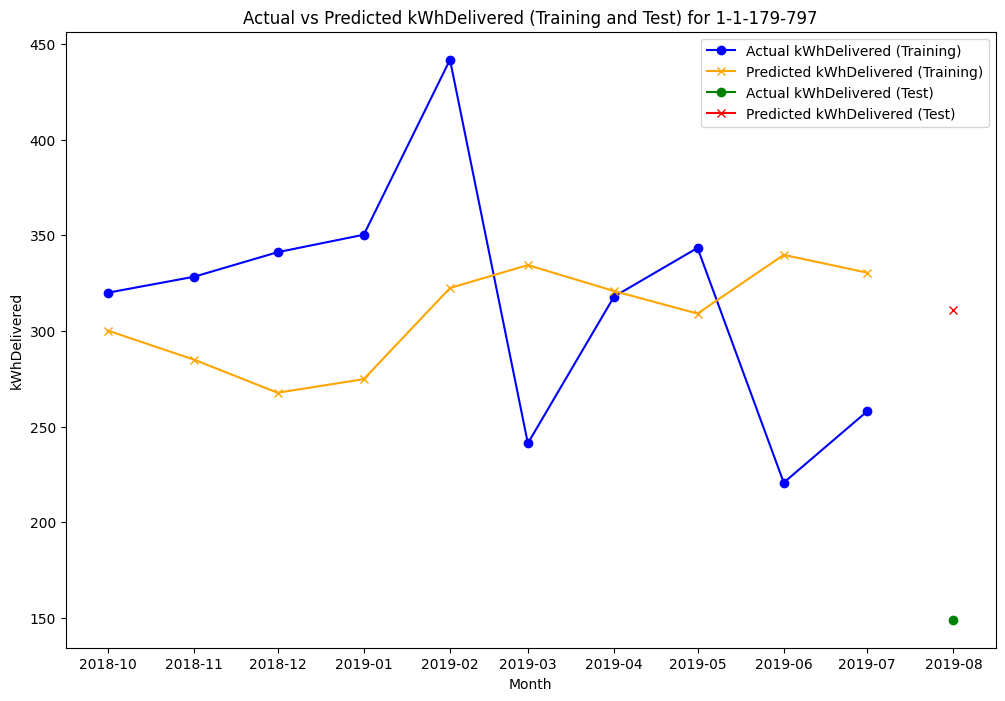

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0427
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0380
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0603
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0476
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0346
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0386
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0541
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0493
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0393
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0413
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0611
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0503
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0354
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0484
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0439
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

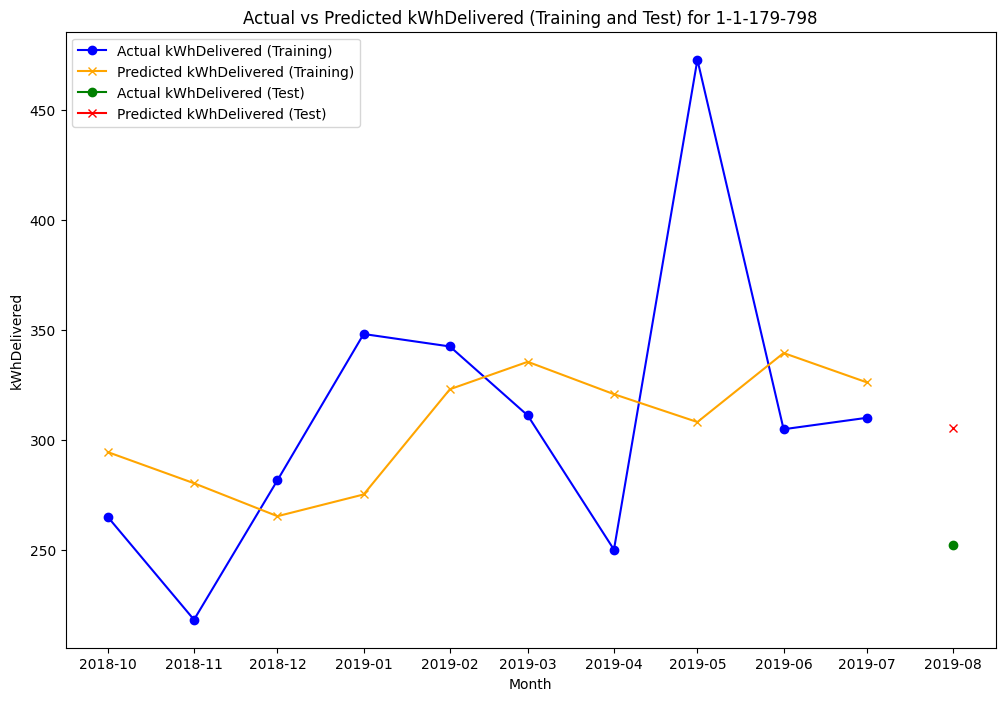

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0915
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0744
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0779
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0819
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0777
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0759
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0927
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0950
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0722
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0840
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0679
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0853
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1003
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0792
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0825
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

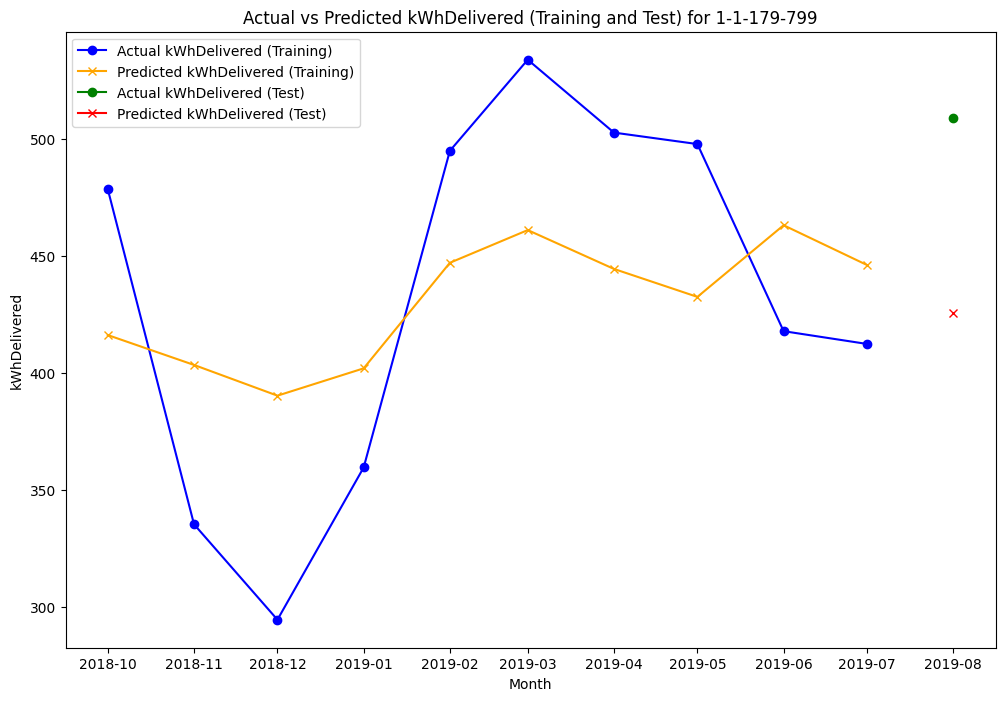

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0729
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0710
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0765
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0556
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0567
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0672
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0684
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0624
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0588
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0689
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0535
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0622
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0488
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0505
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0624
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

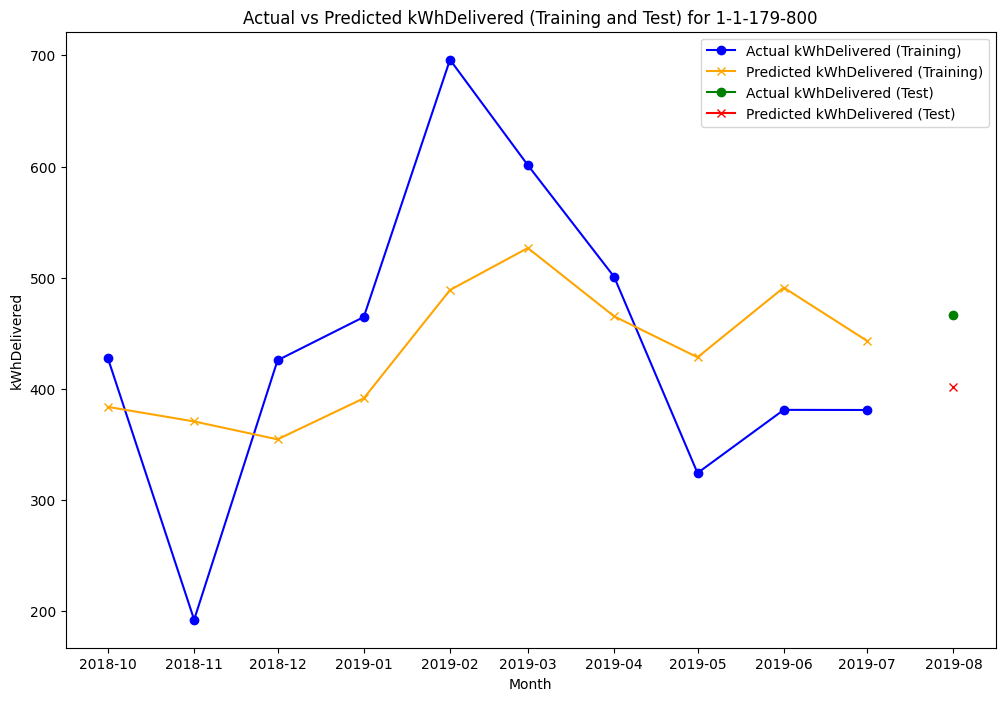

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1016
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0662
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0632
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0782
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0717
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0746
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0708
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0771
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0697
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0670
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0578
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0675
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0870
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0548
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0527
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

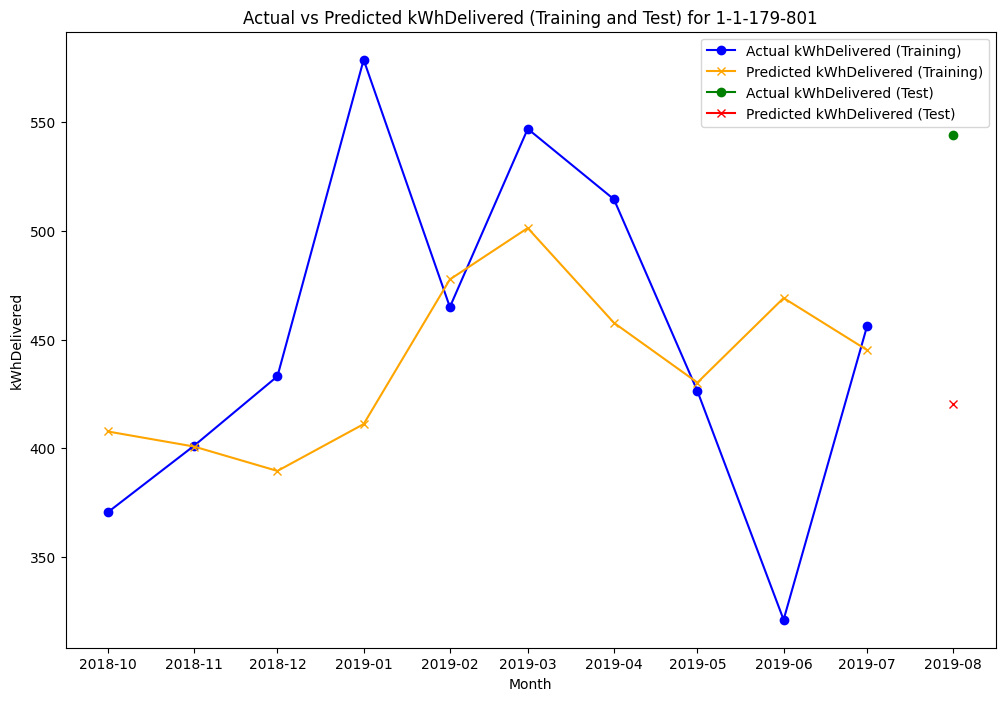

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0446
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0489
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0444
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0479
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0594
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0417
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0503
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0377
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0524
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0368
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0368
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0564
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0550
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0436
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0513
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

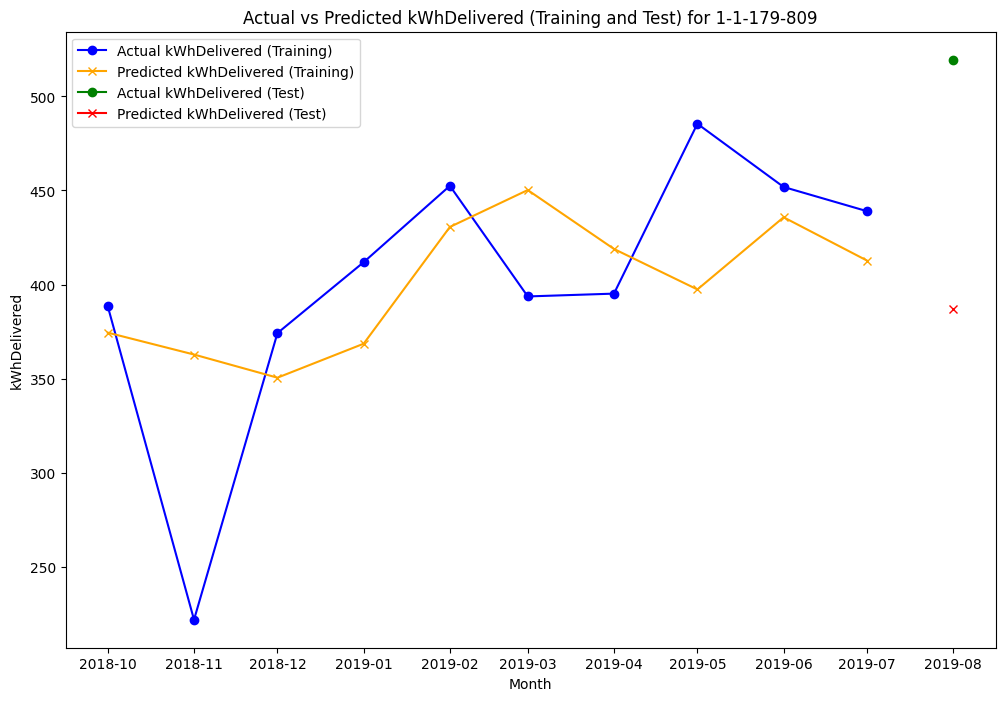

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1083
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0756
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1009
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0917
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1112
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0748
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0808
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0707
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0750
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1001
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0713
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0491
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0912
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0876
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0810
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

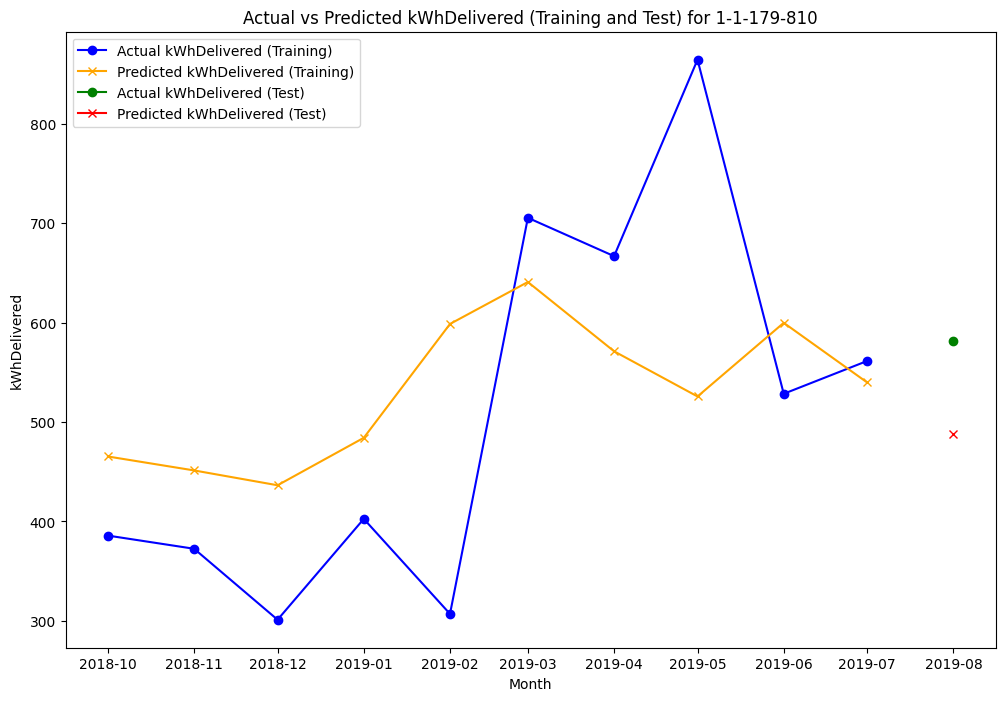

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0845
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0980
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0927
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0951
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0928
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1057
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0812
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0823
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0901
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1033
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0833
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0871
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0726
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0866
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0787
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

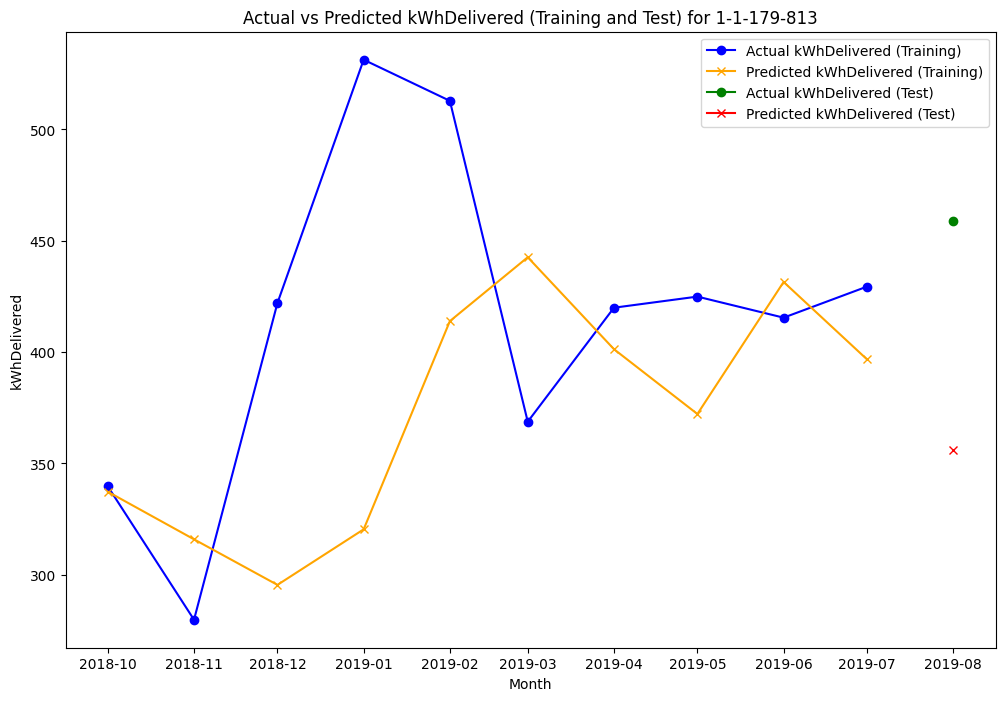

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0739
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0779
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0568
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0565
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0597
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0872
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0731
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0585
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0711
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0695
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0613
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0970
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0729
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0677
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0985
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

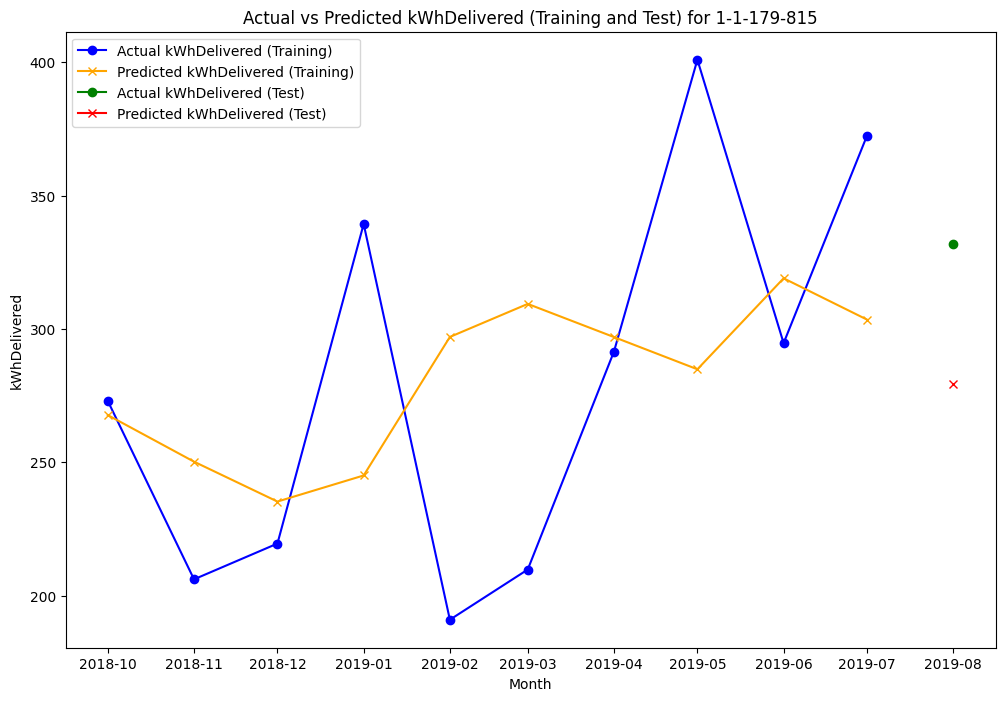

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0426
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0613
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0431
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0494
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0552
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0450
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0562
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0601
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0579
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0620
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0660
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0637
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0357
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0516
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0385
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

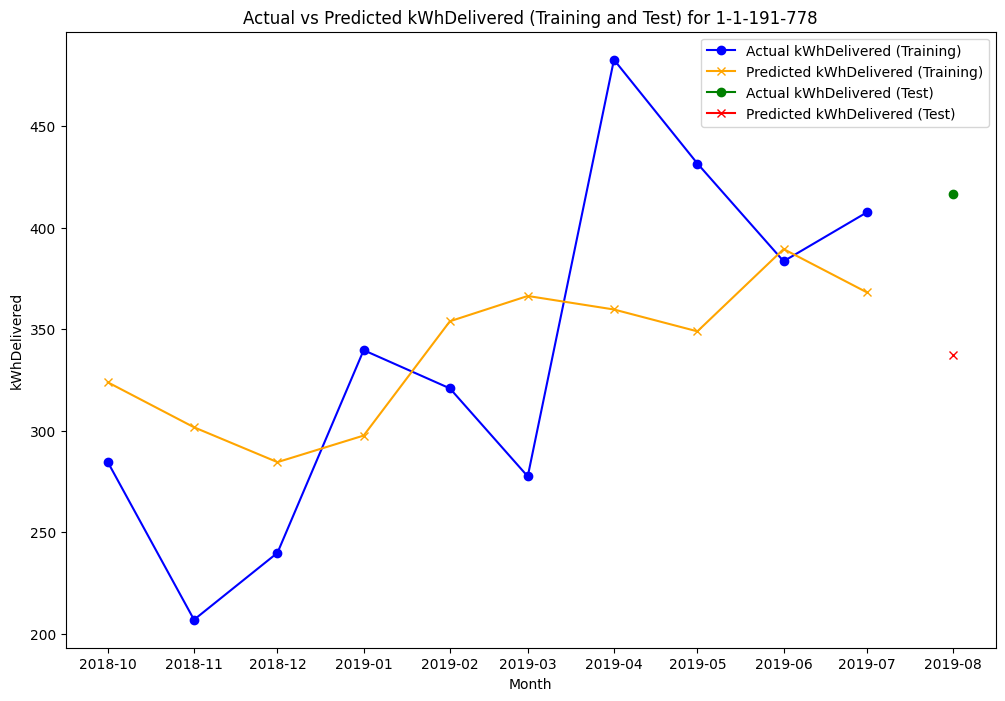

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0392
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0289
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0442
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0225
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0424
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0378
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0316
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0324
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0405
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0402
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0366
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0376
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0524
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0328
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0256
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

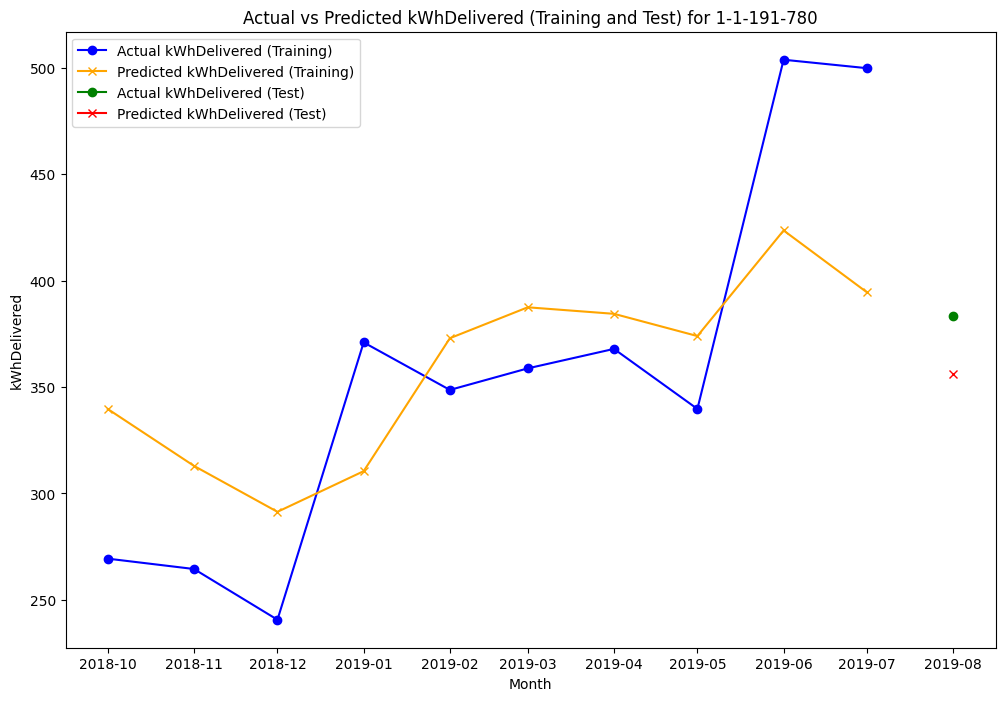

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0722
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1006
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1043
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1025
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1022
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0926
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0666
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0992
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0887
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0761
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0959
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0827
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0777
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0909
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1015
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

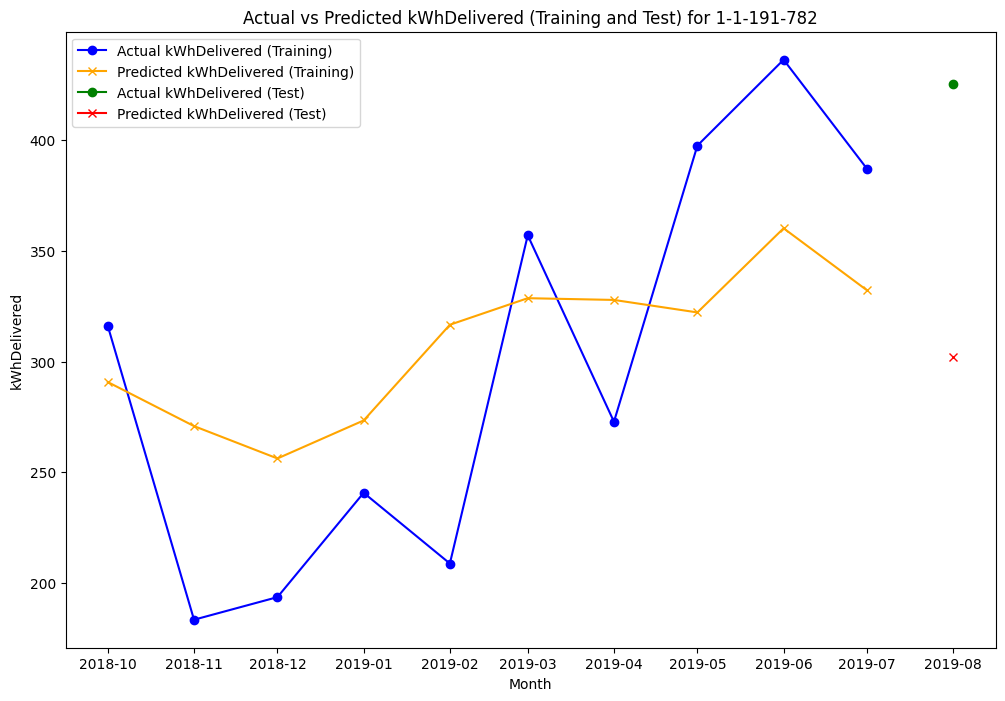

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0371
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0267
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0401
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0231
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0298
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0395
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0272
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0248
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0345
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0302
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0254
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0144
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0359
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0197
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0215
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

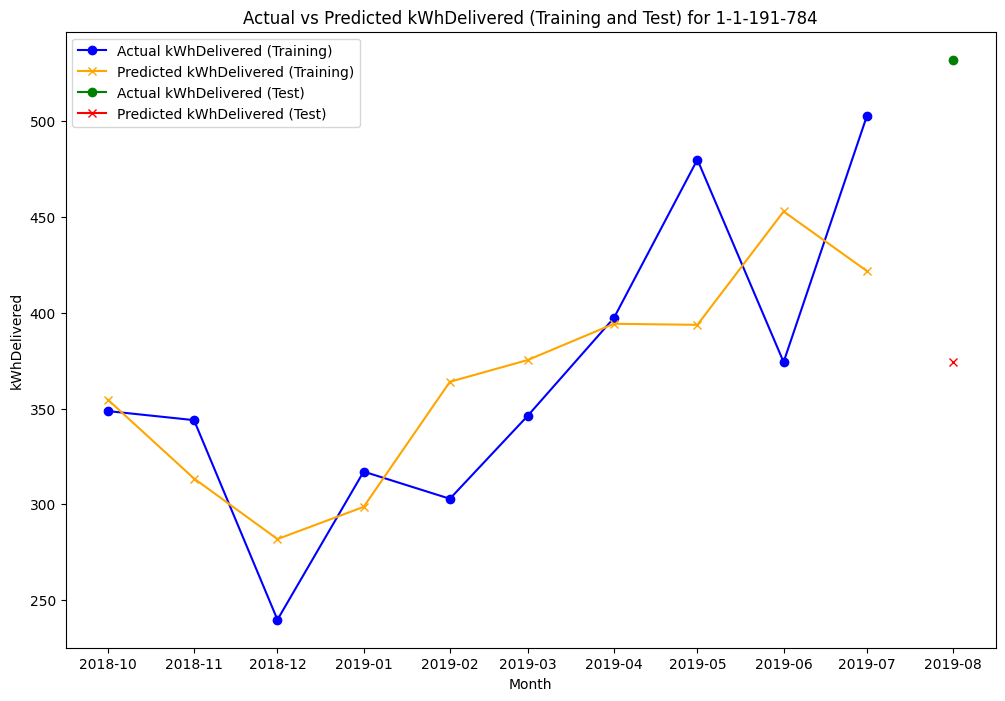

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0617
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0423
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0622
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0312
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0459
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0577
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0518
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0584
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0420
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0501
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0477
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0597
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0353
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0476
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0520
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

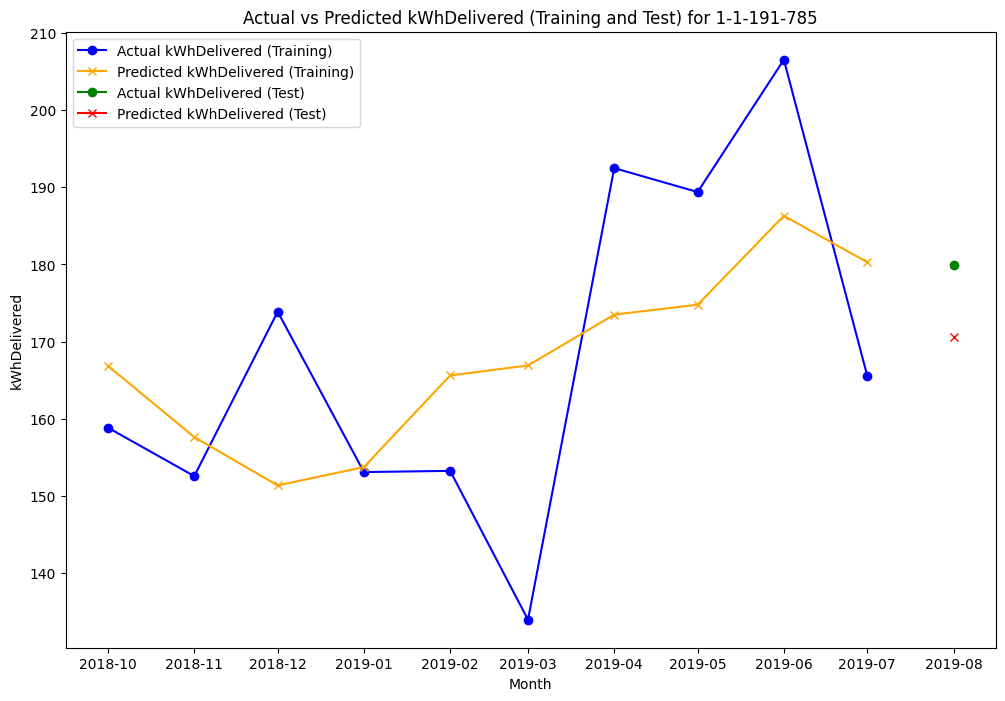

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0636
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0640
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0684
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0837
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0673
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0571
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0589
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0719
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0582
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0685
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0592
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0748
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0845
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0675
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0531
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

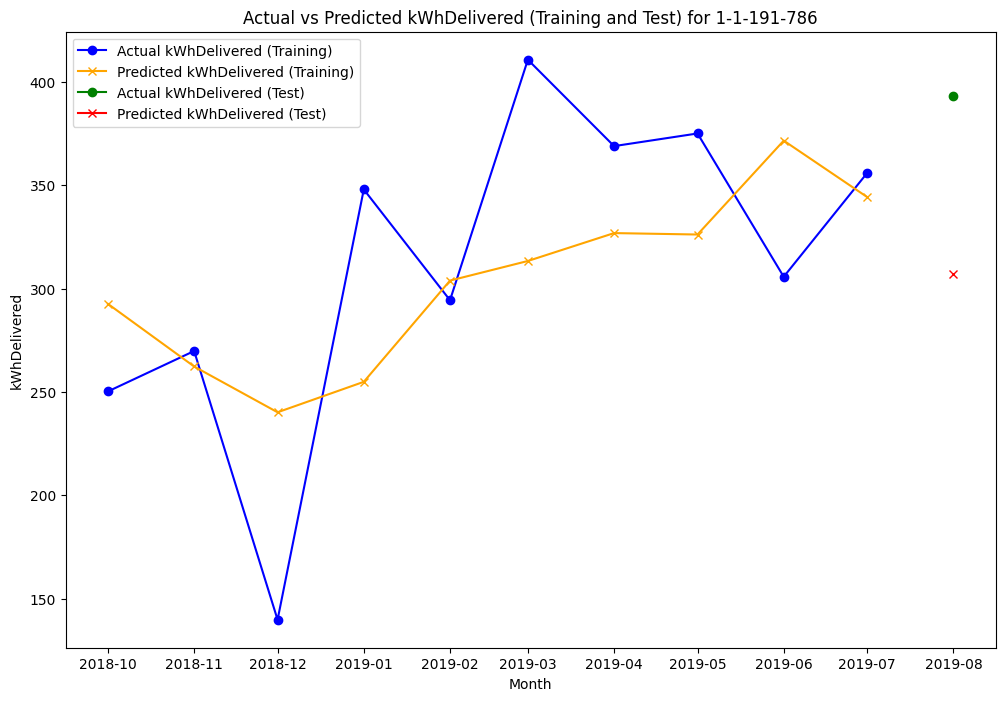

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0849
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0579
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0668
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0651
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0777
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0647
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0677
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0678
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0693
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0534
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0661
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0606
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0548
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0509
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0702
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

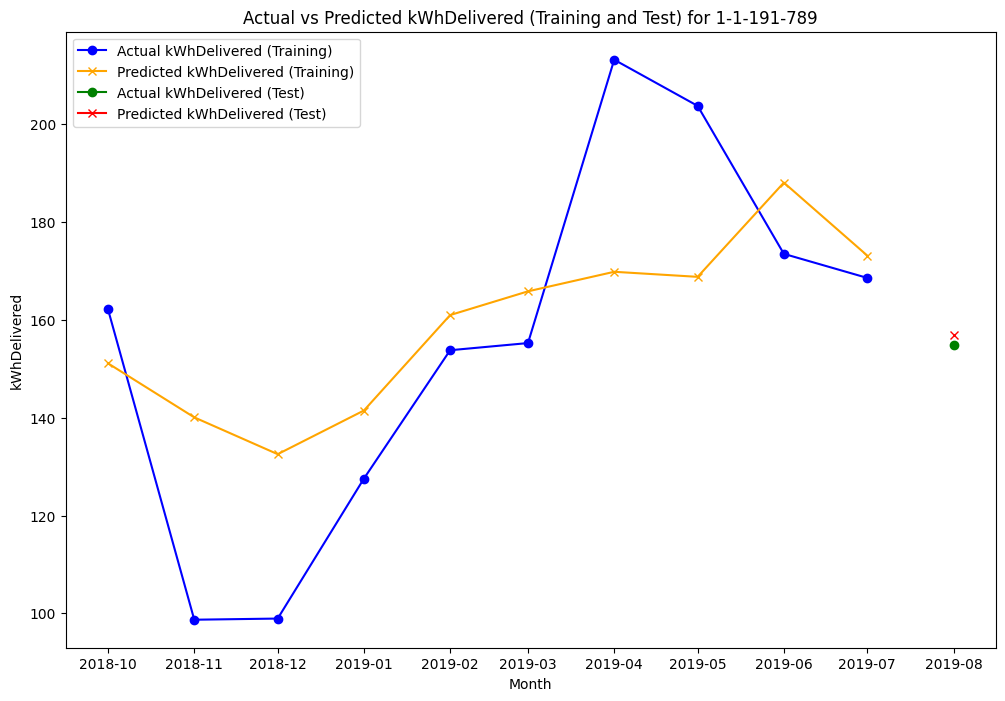

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0587
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0438
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0652
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0473
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0421
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0453
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0482
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0378
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0308
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0385
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0582
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0434
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0437
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0456
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0374
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

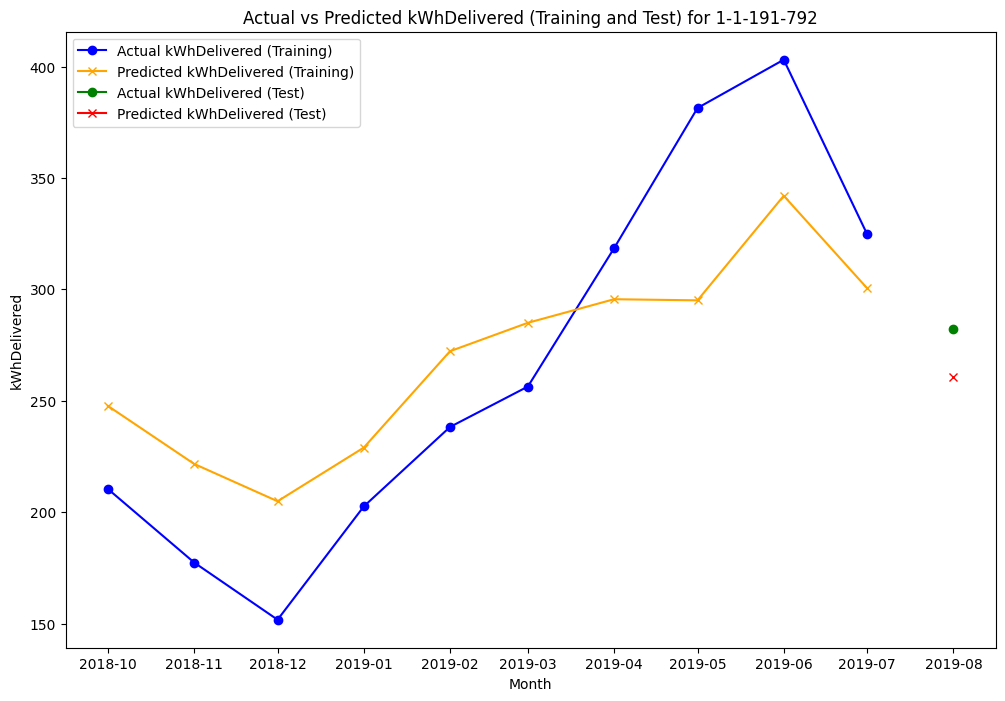

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0548
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0678
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0826
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0749
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0568
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0707
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0683
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0607
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0589
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0677
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0607
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0898
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0594
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0669
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0517
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

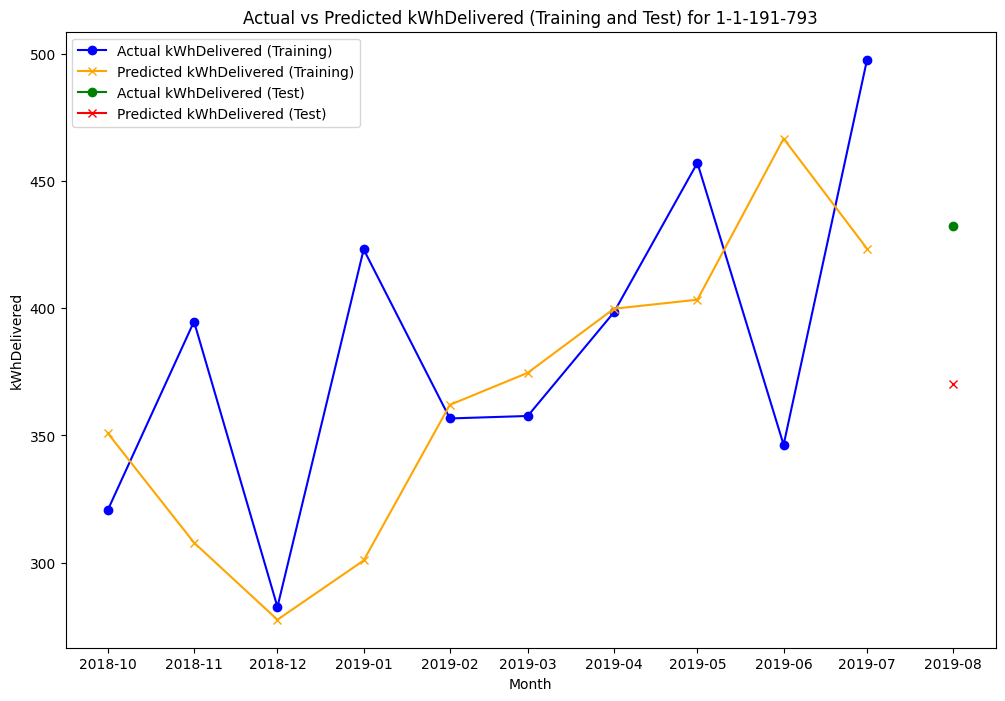

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0416
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0622
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0440
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0425
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0512
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0458
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0534
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0435
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0502
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0624
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0460
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0557
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0496
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0499
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0478
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

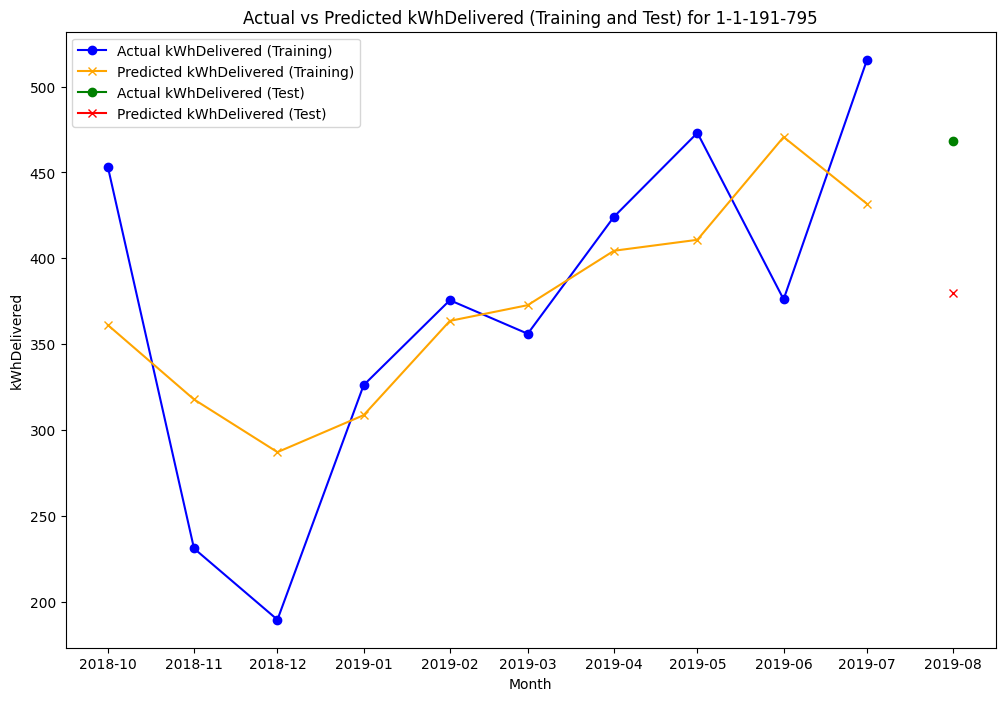

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0786
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0732
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0466
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0634
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0422
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0579
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0757
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0562
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0660
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0667
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0601
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0519
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0516
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0664
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0584
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

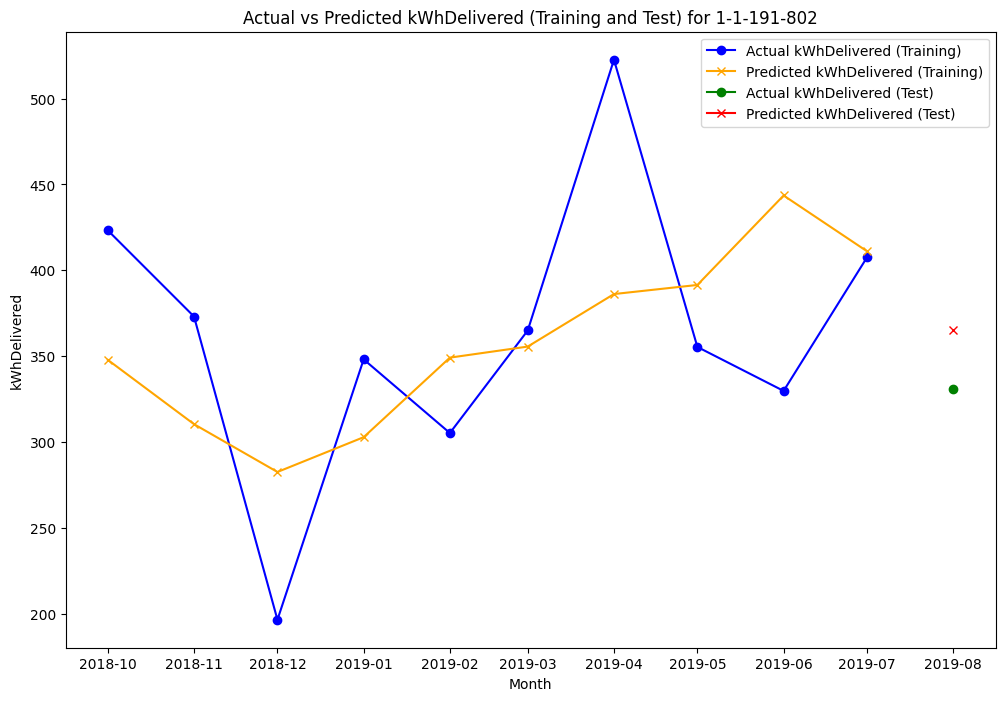

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0673
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0580
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0417
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0453
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0319
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0531
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0505
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0611
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0390
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0472
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0501
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0437
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0489
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0392
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0532
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

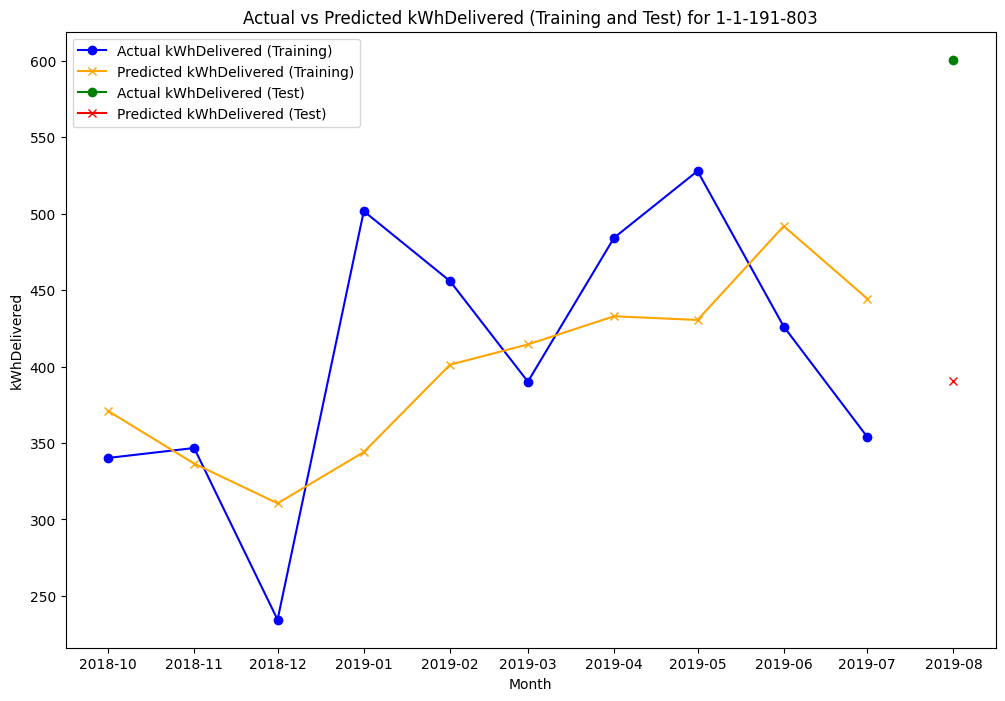

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0733
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0819
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0653
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0739
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0848
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0907
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0814
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0645
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1044
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0976
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0796
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0772
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0819
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0649
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0600
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

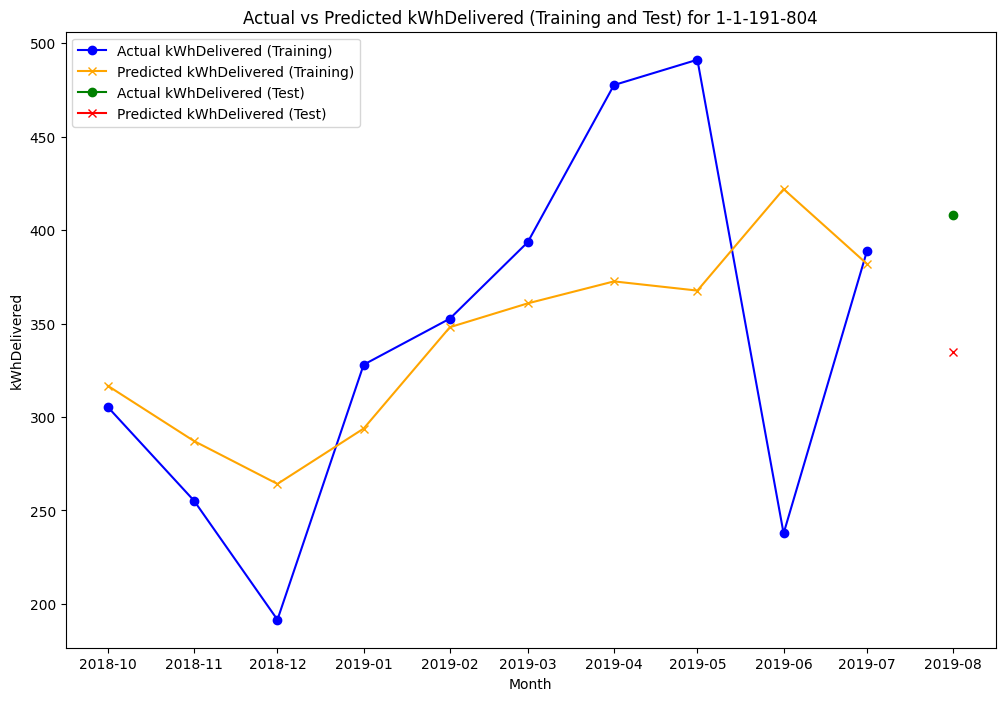

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.0833
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0704
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0775
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0799
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0789
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0760
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0639
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0722
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0597
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0760
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0660
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0820
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0661
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0661
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0823
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

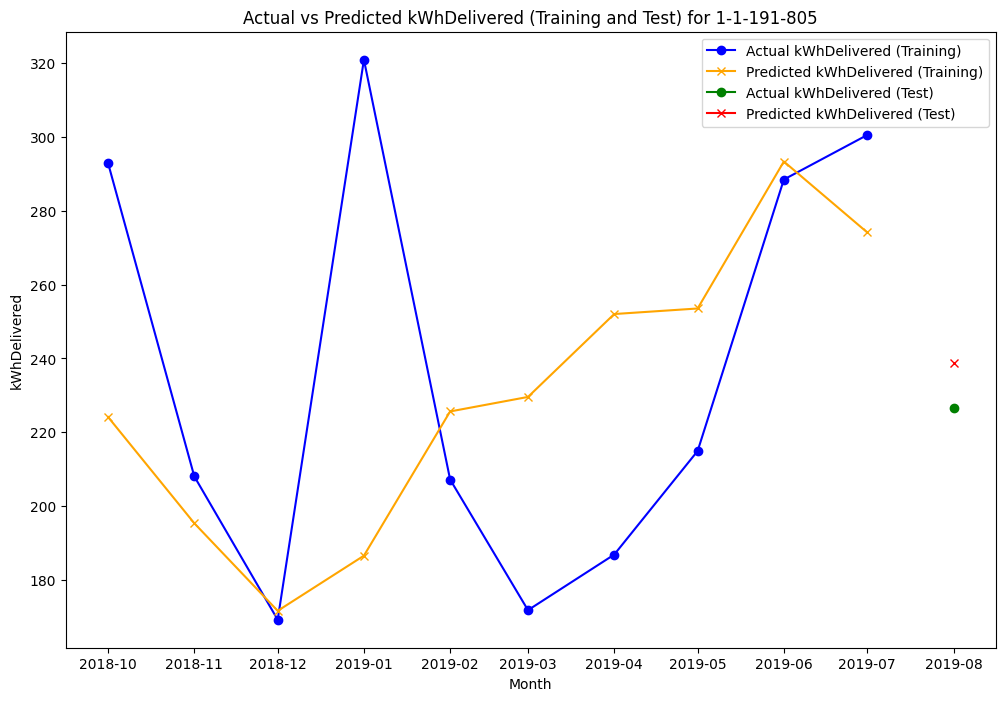

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0264
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0405
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0288
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0415
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0371
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0258
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0294
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0213
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0431
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0420
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0316
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0399
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0339
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0538
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0359
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

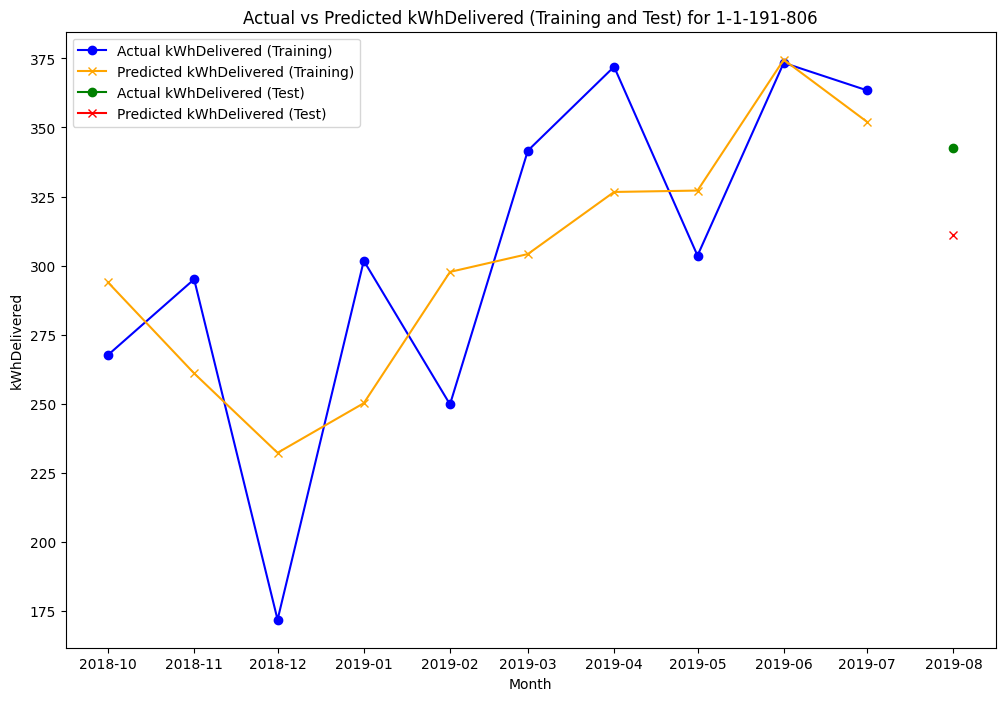

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0578
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0453
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0455
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0511
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0444
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0594
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0526
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0396
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0466
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0472
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0420
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0484
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0454
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0409
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0421
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

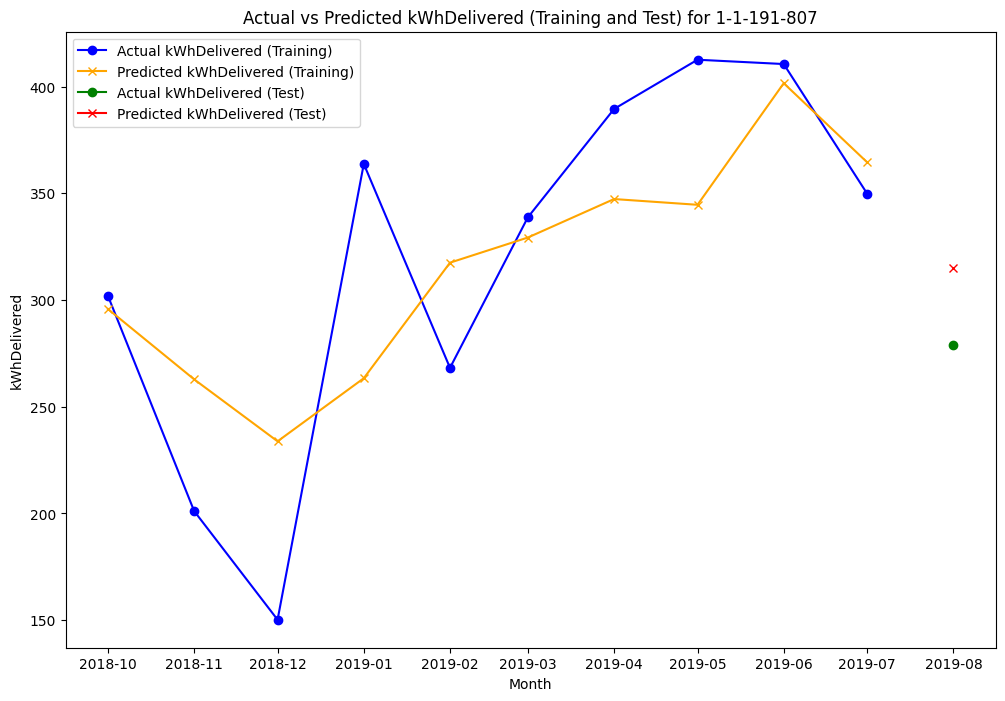

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1294
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1172
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1537
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1229
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1238
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1497
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1368
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1421
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1375
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1243
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1214
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1518
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1498
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1172
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1167
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

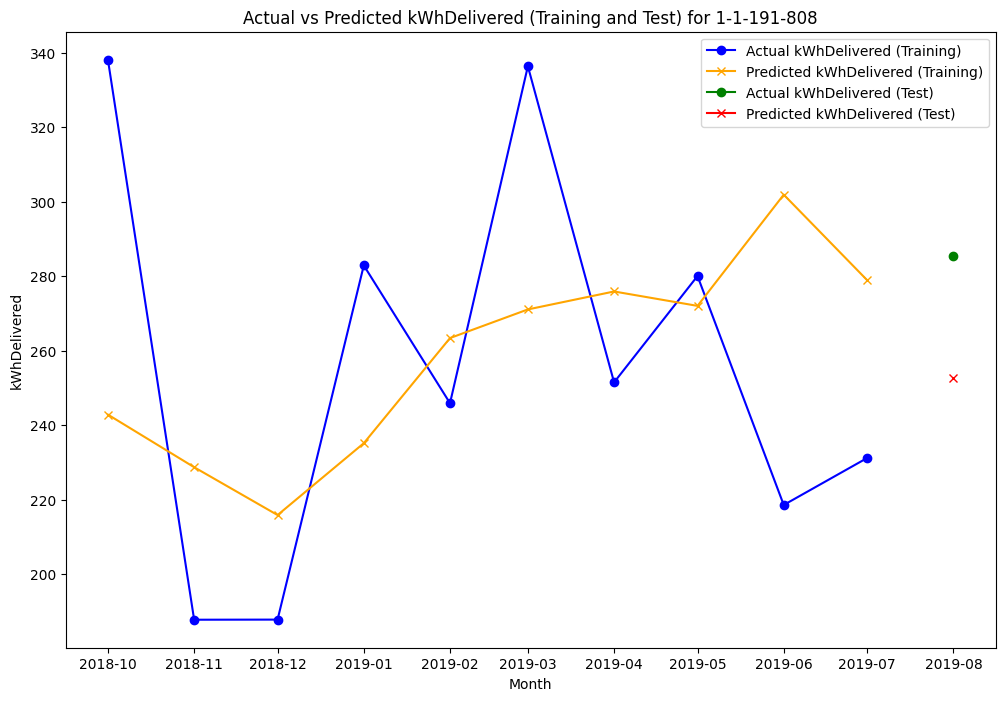

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0577
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0496
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0524
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0386
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0599
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0390
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0503
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0427
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0229
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0434
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0566
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0415
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0448
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0364
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0485
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

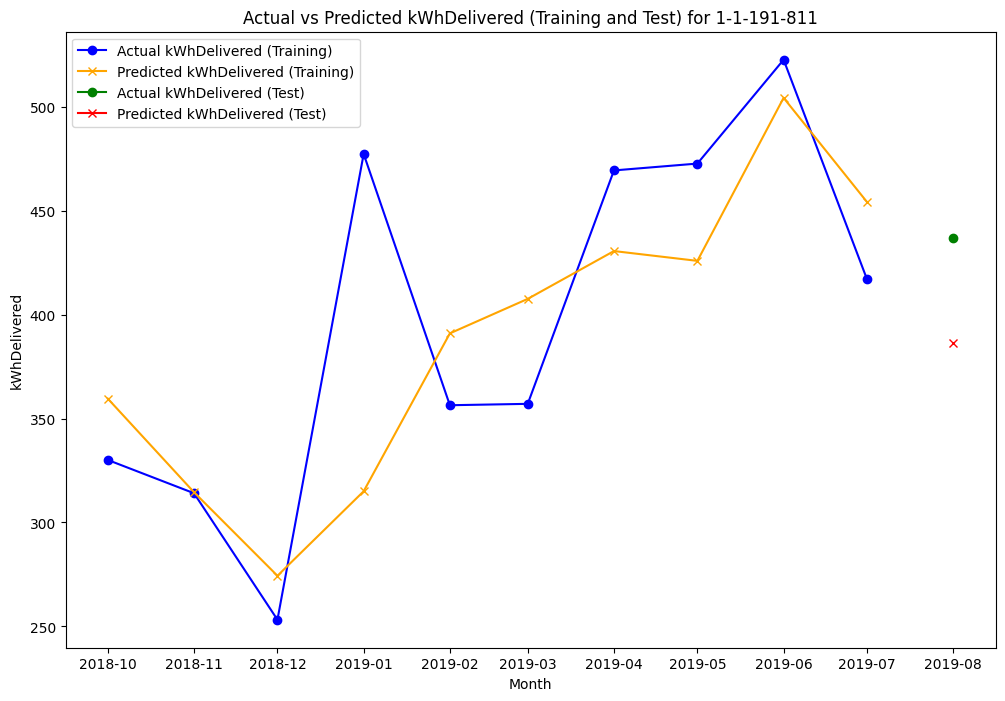

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0761
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0714
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0620
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0642
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0562
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0629
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0626
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0656
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0687
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0450
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0757
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0435
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0666
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0575
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0777
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

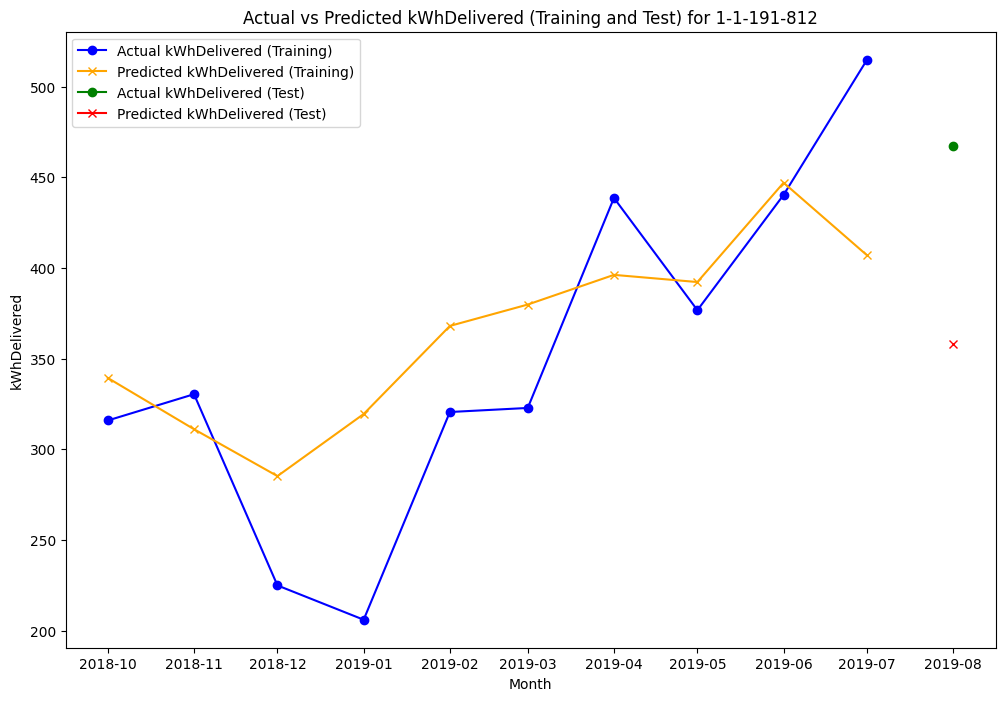

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0570
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0702
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0705
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0542
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0600
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0649
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0537
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0678
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0568
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0689
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0388
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0473
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0493
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0617
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0470
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

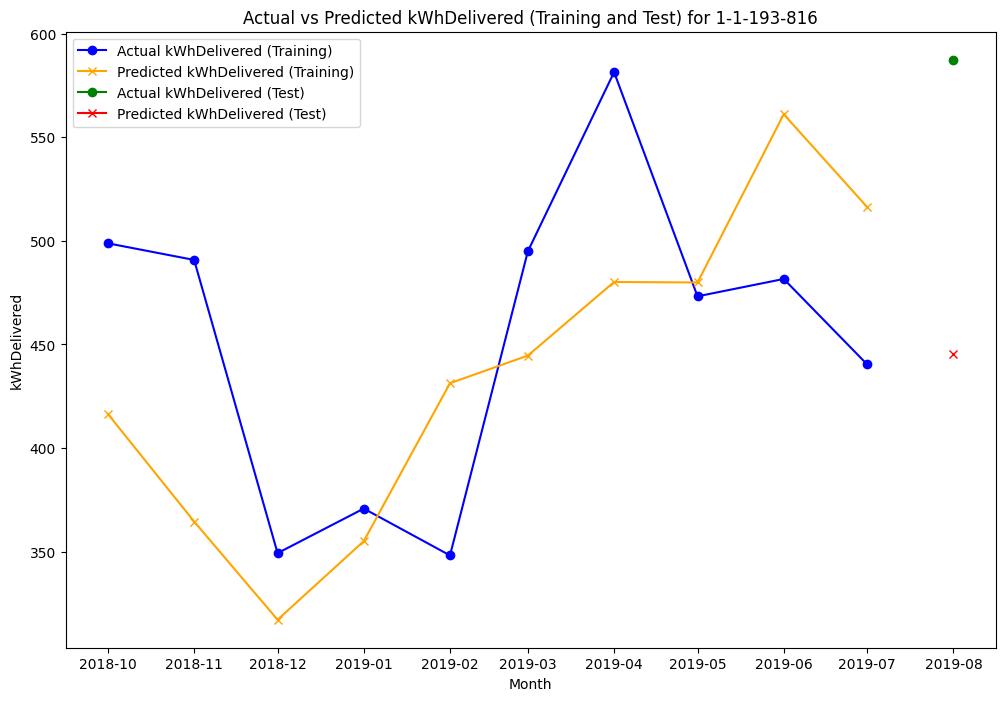

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0275
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0171
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0176
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0115
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0362
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0217
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0232
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0158
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0238
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0224
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0274
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0193
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0312
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0300
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0150
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

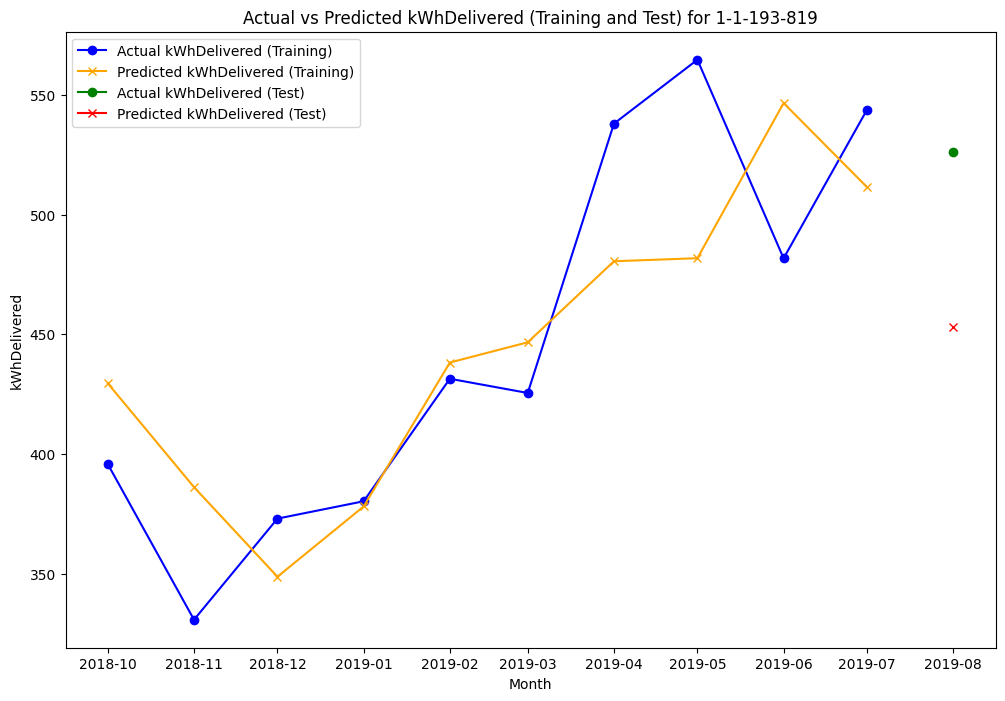

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0428
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0340
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0455
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0414
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0346
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0298
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0561
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0477
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0522
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0387
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0280
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0383
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0395
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0307
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0257
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

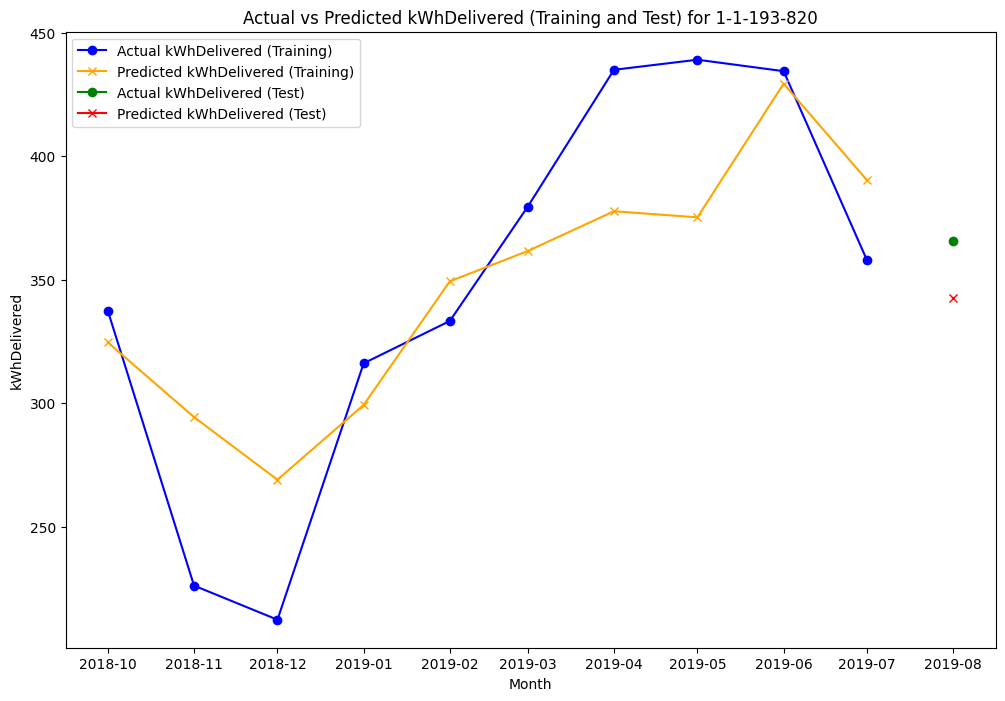

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0450
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0448
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0454
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0678
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0491
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0685
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0557
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0697
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0458
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0550
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0532
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0606
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0548
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0524
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0448
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

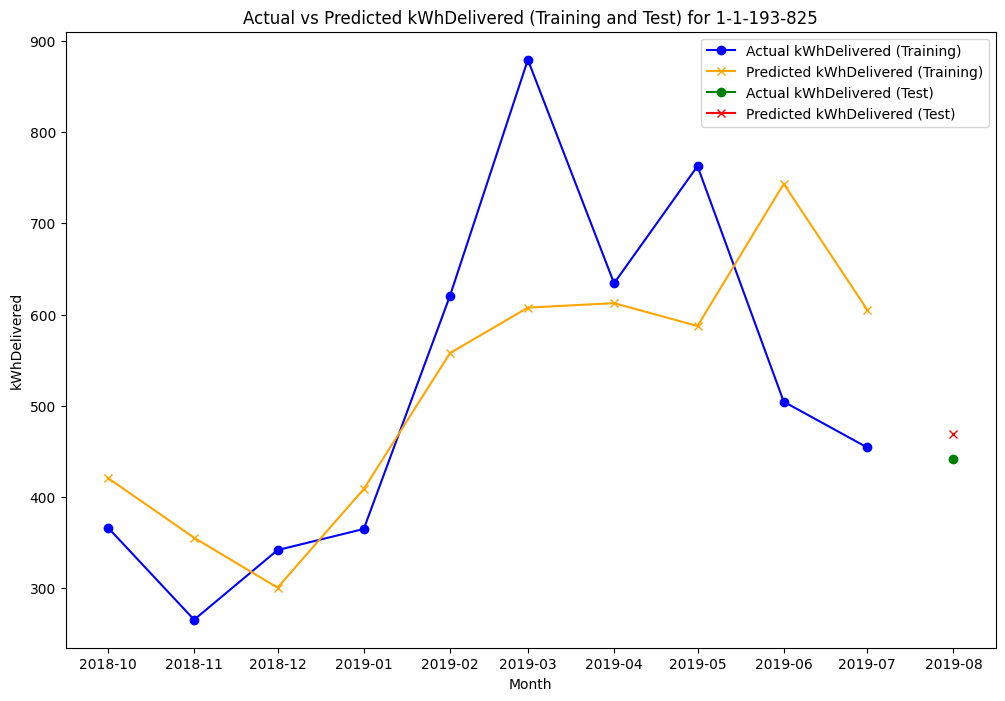

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0972
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0884
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0762
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0766
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0691
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0871
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0992
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0693
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0723
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0870
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0634
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1031
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0533
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0667
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0669
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

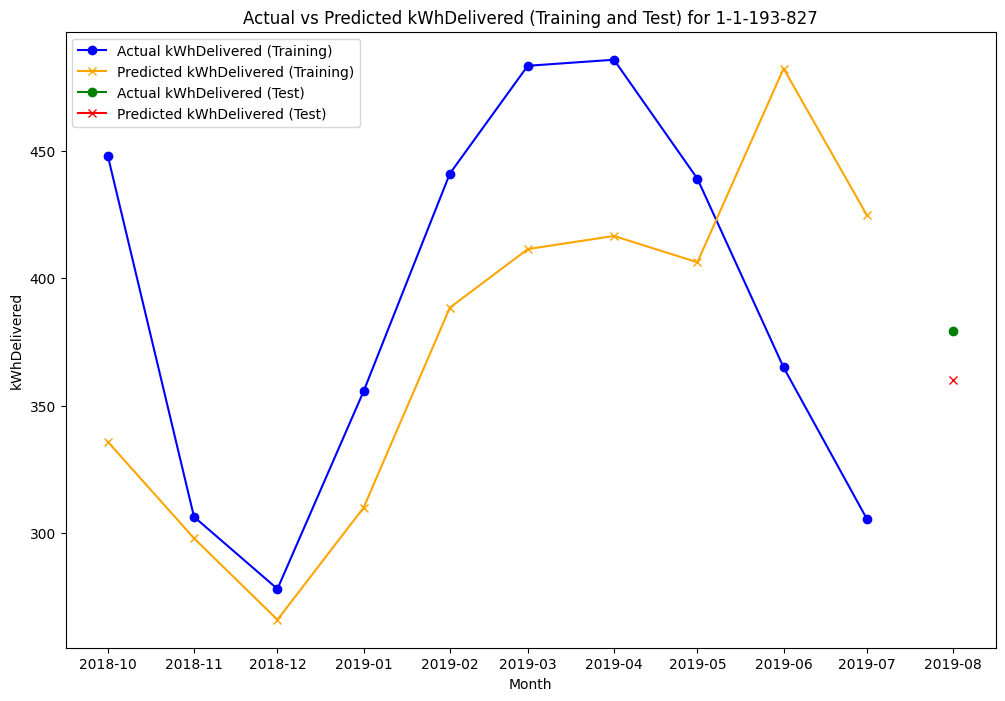

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0481
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0657
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0562
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0860
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0700
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0669
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0660
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0423
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0490
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0395
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0714
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0435
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0613
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0393
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0481
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

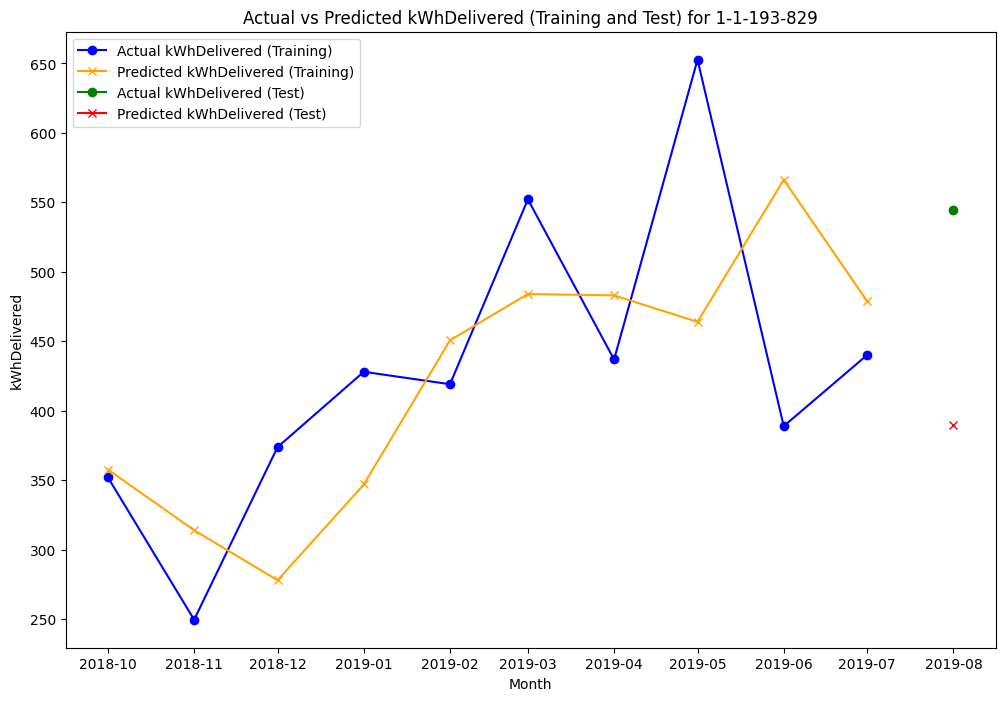

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0520
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0528
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0404
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0488
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0646
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0452
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0446
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0431
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0497
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0298
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0474
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0536
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0413
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0442
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0442
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

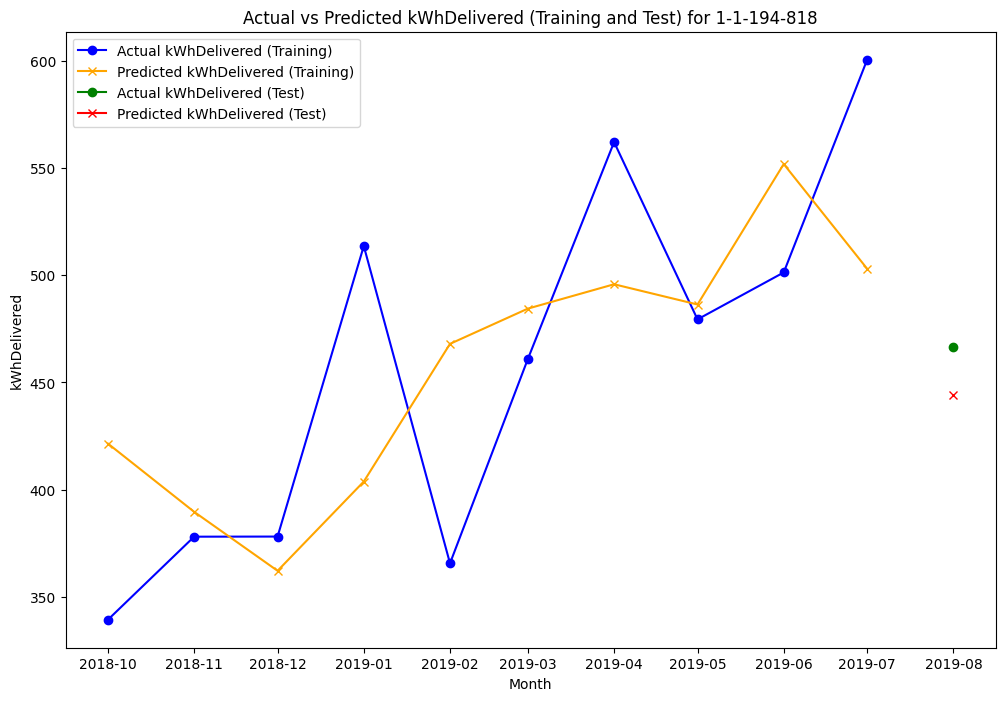

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0759
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0564
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0843
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0700
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0636
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0742
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0626
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0723
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0614
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0643
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0724
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0626
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0567
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0817
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0686
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

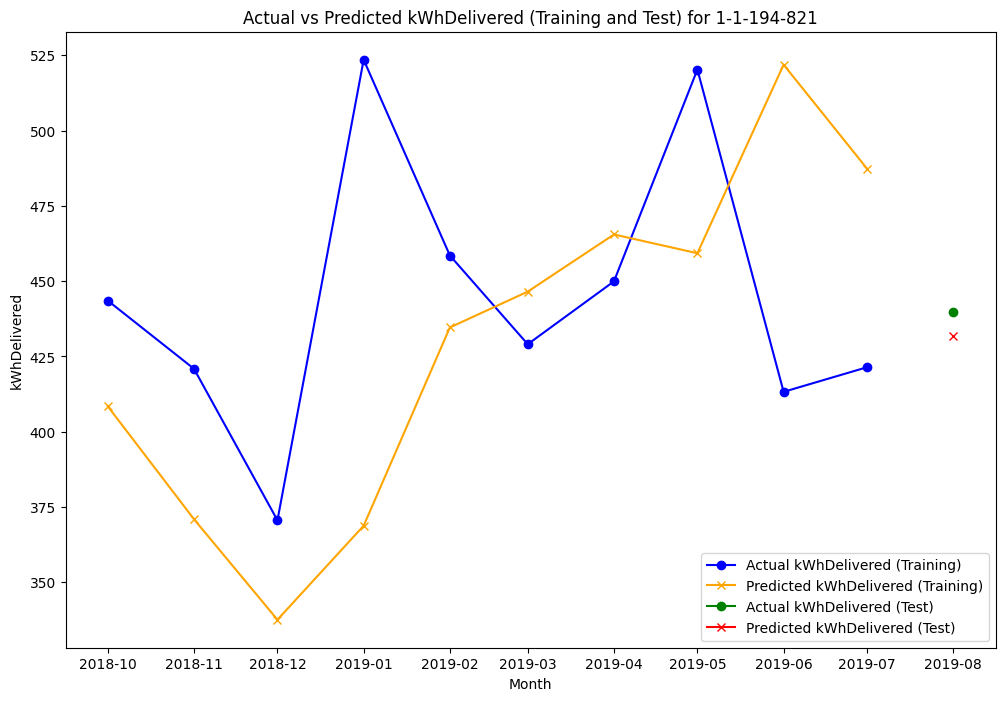

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0795
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0759
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0630
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0886
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1015
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0751
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0597
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0910
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0957
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0887
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0647
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0725
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0722
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0684
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0888
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

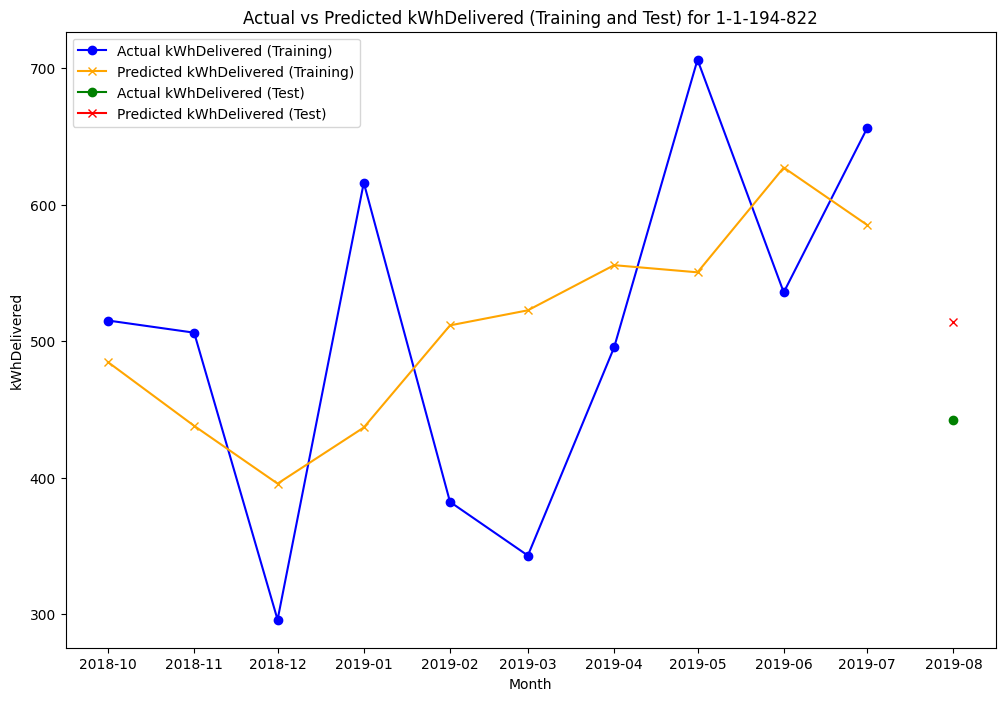

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0680
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0733
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0645
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0518
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0584
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0554
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0490
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0716
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0540
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0738
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0501
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0741
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0751
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0661
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0585
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

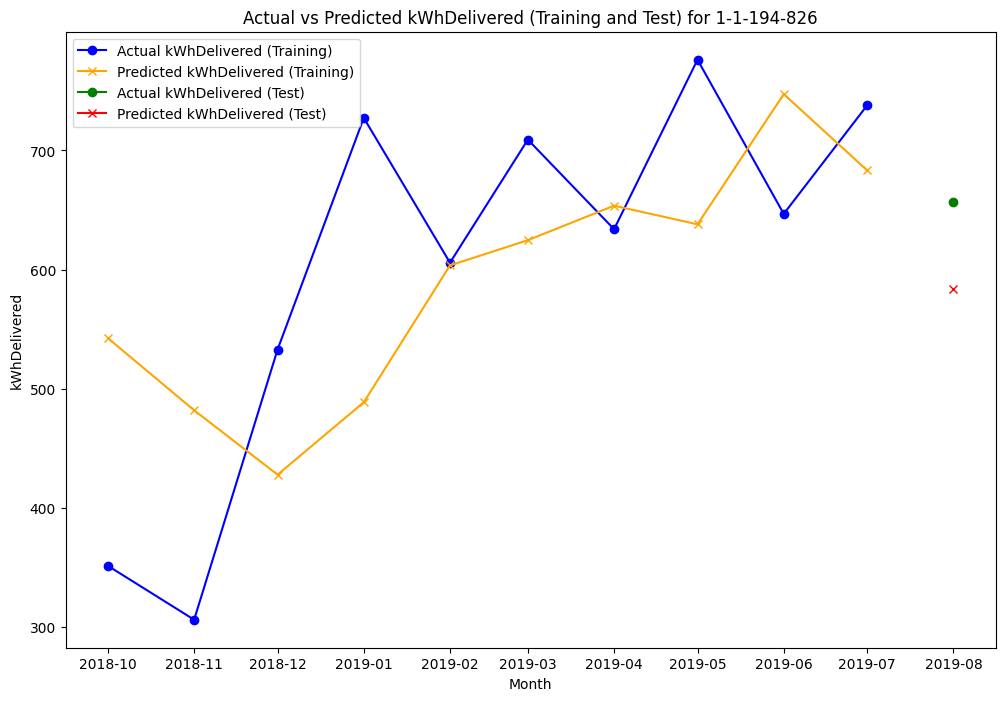

In [48]:
# Initialize a dictionary to store the models and metrics
models = {}
metrics = {}

# Directory containing the CSV files
directory = "./jpl_model_data"  # Replace with your directory path

# List all files in the directory
filenames = sorted([filename for filename in os.listdir(directory) if filename.endswith('.csv')])

# Placeholder to store the first trained model for Transfer Learning
previous_model = None

def prepare_data(features, target):
    # For window_size = 1, each sample is its own sequence
    return features, target

def build_gru_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(GRU(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

def inverse_transform(scaler, data):
    return scaler.inverse_transform(data.reshape(-1, 1)).flatten()

def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i+sequence_length][features].values
        label = data.iloc[i+sequence_length]['Scaled_kWhDelivered']
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

# Loop through each CSV file in the directory
for filename in filenames:
    try:
        filepath = os.path.join(directory, filename)
        # Load the data from the CSV file
        data = pd.read_csv(filepath)
        
        # Convert the month to datetime format and set it as the index
        data['Month'] = pd.to_datetime(data['month'])
        data.set_index('Month', inplace=True)
    
        # Select the features (weather data) and target variable (kWhDelivered)
        stationID = filename.split('.')[0]  # Example: If filename is 'station1.csv'
        features = ['MinTemp', 'MaxTemp', 'AvgTemp', 'AvgPrecipitation', 'AvgHumidity', 'AvgWindSpeed']
        target = 'kWhDelivered'
    
        # Scale the features
        scaler = MinMaxScaler()
        scaled_features = scaler.fit_transform(data[features])
    
        # Scale the target variable (kWhDelivered) separately
        target_scaler = MinMaxScaler()
        scaled_target = target_scaler.fit_transform(data[[target]])  # Use double brackets to keep it as a DataFrame
        data['Scaled_kWhDelivered'] = scaled_target
    
        # Convert the scaled features back to a DataFrame
        scaled_features_df = pd.DataFrame(scaled_features, columns=features, index=data.index)
    
        # Combine the scaled features with the scaled target variable
        scaled_data = pd.concat([scaled_features_df, data['Scaled_kWhDelivered']], axis=1)
    
        # Set the sequence length (e.g., 1 for 1 months of data)
        sequence_length = 1
    
        # Create sequences and targets
        X, y = create_sequences(scaled_data, sequence_length)
    
        # Split the data into training and testing sets (use all except the last one for training)
        X_train, X_test = X[:-1], X[-1:]
        y_train, y_test = y[:-1], y[-1:]
    
        # Extract the months corresponding to the training and test data
        months_train = data.index[sequence_length:len(X_train)+sequence_length]
        months_test = data.index[-len(X_test):]
    
        # Define the GRU model
        input_shape = (X_train.shape[1], X_train.shape[2])
        model = build_gru_model(input_shape)
    
        # Compile the model
        model.compile(optimizer=Adam(learning_rate=0.0001), loss=MeanSquaredError())
    
        # If there is a previously trained model, load its weights for transfer learning
        if previous_model is not None:
            model.set_weights(previous_model.get_weights())  # Transfer weights from previous model
        
        # Train the model
        model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)
       
        # Predict the values for both training and test sets
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
    
        # Reshape y_train, y_test, y_train_pred, and y_test_pred for inverse transformation
        y_train_scaled = y_train.reshape(-1, 1)
        y_test_scaled = y_test.reshape(-1, 1)
        y_train_pred_scaled = y_train_pred.reshape(-1, 1)
        y_test_pred_scaled = y_test_pred.reshape(-1, 1)
    
        # Inverse transform the predictions and actual values using the target scaler
        y_train_inversed = target_scaler.inverse_transform(y_train_scaled)
        y_test_inversed = target_scaler.inverse_transform(y_test_scaled)
        y_train_pred_inversed = target_scaler.inverse_transform(y_train_pred_scaled)
        y_test_pred_inversed = target_scaler.inverse_transform(y_test_pred_scaled)
    
        mse = mean_squared_error(y_test_inversed, y_test_pred_inversed)
        mae = mean_absolute_error(y_test_inversed, y_test_pred_inversed)
        smape_value = smape(y_test_inversed, y_test_pred_inversed)
        
        # Store the model and metrics
        models[stationID] = model
        metrics[stationID] = {
            'MAE': mae,
            'MSE': mse,
            'SMAPE (%)': smape_value,
            'Actual kWh': y_test_inversed[0][0],
            'Predicted kWh': y_test_pred_inversed[0][0]
        }
    
        # Plot the actual vs predicted values against the month for both training and test sets
        plt.figure(figsize=(12, 8))
    
        # Plot training data
        plt.plot(months_train, y_train_inversed, label='Actual kWhDelivered (Training)', marker='o', color='blue')
        plt.plot(months_train, y_train_pred_inversed, label='Predicted kWhDelivered (Training)', marker='x', color='orange')
    
        # Plot test data
        plt.plot(months_test, y_test_inversed, label='Actual kWhDelivered (Test)', marker='o', color='green')
        plt.plot(months_test, y_test_pred_inversed, label='Predicted kWhDelivered (Test)', marker='x', color='red')
    
        plt.title(f'Actual vs Predicted kWhDelivered (Training and Test) for {stationID}')
        plt.xlabel('Month')
        plt.ylabel('kWhDelivered')
        plt.legend()
        plt.show()
    
        # Update the previous model for transfer learning
        previous_model = model
    except Exception as e:
        print(f"An error occurred with station {filename}: {e}")
        continue  # Skip to the next file if there's an error

In [40]:
metrics_df = pd.DataFrame.from_dict(metrics, orient='index').reset_index()

# Rename the index column to 'stationID'
metrics_df = metrics_df.rename(columns={'index': 'stationID'})

metrics_df

stationID         MAE           MSE  SMAPE (%)  Actual kWh  \
0   1-1-178-817  207.545405  43075.094946  56.369212  471.962000   
1   1-1-178-823  307.161275  94348.049100  53.303627  729.829000   
2   1-1-178-824   88.134861   7767.753738  18.976033  508.521000   
3   1-1-178-828   69.849326   4878.928367  11.922420  620.790000   
4   1-1-179-777  116.498553  13571.912960  32.628144  298.800000   
5   1-1-179-779   42.737968   1826.533889  10.163052  399.154000   
6   1-1-179-781   92.690482   8591.525532  24.193226  429.471000   
7   1-1-179-783   99.825269   9965.084291  29.377081  289.894000   
8   1-1-179-787   37.231341   1386.172739  12.721430  311.282000   
9   1-1-179-788   30.207159    912.472466   8.440927  372.969000   
10  1-1-179-790  130.417052  17008.607517  41.742470  247.224000   
11  1-1-179-791    6.640927     44.101908   1.908425  344.659000   
12  1-1-179-794   46.256336   2139.648614  14.051825  352.312000   
13  1-1-179-796   31.188434    972.718390   7.837771  413.519000   
14  1-1-179-797  171.333886  29355.300404  73.011824  148.999000   
15  1-1-179-798   56.285910   3168.103655  20.064779  252.378000   
16  1-1-179-799   76.831424   5903.067725  16.327578  508.978000   
17  1-1-179-800   58.478045   3419.681709  13.370628  466.601000   
18  1-1-179-801  116.962252  13680.168387  24.095473  543.892855   
19  1-1-179-809  130.289443  16975.338924  28.675801  519.498000   
20  1-1-179-810   90.742028   8234.115571  16.923200  581.570000   
21  1-1-179-813   90.239112   8143.097257  21.805501  458.956000   
22  1-1-179-815   46.425772   2155.352303  15.047209  331.747000   
23  1-1-191-778   73.618782   5419.725132  19.390529  416.473000   
24  1-1-191-780   17.989286    323.614409   4.803624  383.488706   
25  1-1-191-782  118.549991  14054.100416  32.400977  425.159000   
26  1-1-191-784  146.558647  21479.437087  31.934469  532.214928   
27  1-1-191-785    6.838665     46.767338   3.873288  179.979000   
28  1-1-191-786   79.866352   6378.634229  22.593614  393.424000   
29  1-1-191-789    2.811592      7.905047   1.799052  154.876000   
30  1-1-191-792   15.473042    239.415044   5.639779  282.092000   
31  1-1-191-793   46.762253   2186.708323  11.436385  432.271286   
32  1-1-191-795   82.727295   6843.805325  19.362223  468.625000   
33  1-1-191-802   42.265985   1786.413518  11.995387  331.219000   
34  1-1-191-803  201.675960  40673.192893  40.353610  600.609767   
35  1-1-191-804   70.042685   4905.977695  18.777920  408.026907   
36  1-1-191-805   17.664643    312.039628   7.502333  226.623000   
37  1-1-191-806   26.801513    718.321083   8.146350  342.401000   
38  1-1-191-807   43.775568   1916.300351  14.549053  278.994818   
39  1-1-191-808   30.735593    944.676648  11.377553  285.510174   
40  1-1-191-811   43.089439   1856.699729  10.378589  436.721000   
41  1-1-191-812  104.582439  10937.486489  25.212873  467.089000   
42  1-1-193-816  127.794566  16331.451150  24.410902  587.411601   
43  1-1-193-819   69.272930   4798.738848  14.091174  526.241558   
44  1-1-193-820   19.686755    387.568337   5.532216  365.700000   
45  1-1-193-825   26.710159    713.432577   5.878503  441.015000   
46  1-1-193-827   14.102491    198.880251   3.788021  379.343000   
47  1-1-193-829  150.505346  22651.859085  32.070292  544.551000   
48  1-1-194-818   19.242580    370.276879   4.210670  466.617000   
49  1-1-194-821    0.460071      0.211666   0.104661  439.812000   
50  1-1-194-822   84.514399   7142.683626  17.435025  442.482000   
51  1-1-194-826   61.404921   3770.564371   9.802508  657.123000   

    Predicted kWh  
0      264.416595  
1      422.667725  
2      420.386139  
3      550.940674  
4      415.298553  
5      441.891968  
6      336.780518  
7      389.719269  
8      274.050659  
9      342.761841  
10     377.641052  
11     351.299927  
12     306.055664  
13     382.330566  
14     320.332886  
15     308.663910  
16     432.146576  
17     408.122955  
18     426.930603  
1

### Without Transfer learning

In [47]:
# Initialize a dictionary to store the models and metrics
models = {}
metrics = {}

# Directory containing the CSV files
directory = "./jpl_model_data"  # Replace with your directory path

# List all files in the directory
filenames = sorted([filename for filename in os.listdir(directory) if filename.endswith('.csv')])

# Placeholder to store the first trained model for Transfer Learning
previous_model = None

def prepare_data(features, target):
    # For window_size = 1, each sample is its own sequence
    return features, target

def build_gru_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Input(shape=input_shape))
    model.add(GRU(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

def inverse_transform(scaler, data):
    return scaler.inverse_transform(data.reshape(-1, 1)).flatten()

# Create a lagged feature for kWhDelivered
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i+sequence_length][features].values
        label = data.iloc[i+sequence_length]['Scaled_kWhDelivered']
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)



# Loop through each CSV file in the directory
for filename in filenames:
    try:
        filepath = os.path.join(directory, filename)
        # Load the data from the CSV file
        data = pd.read_csv(filepath)
        
        # Convert the month to datetime format and set it as the index
        data['Month'] = pd.to_datetime(data['month'])
        data.set_index('Month', inplace=True)
    
        # Select the features (weather data) and target variable (kWhDelivered)
        stationID = filename.split('.')[0]  # Example: If filename is 'station1.csv'
        features = ['MinTemp', 'MaxTemp', 'AvgTemp', 'AvgPrecipitation', 'AvgHumidity', 'AvgWindSpeed']
        target = 'kWhDelivered'
    
        # Scale the features
        scaler = MinMaxScaler()
        scaled_features = scaler.fit_transform(data[features])
    
        # Scale the target variable (kWhDelivered) separately
        target_scaler = MinMaxScaler()
        scaled_target = target_scaler.fit_transform(data[[target]])  # Use double brackets to keep it as a DataFrame
        data['Scaled_kWhDelivered'] = scaled_target
    
        # Convert the scaled features back to a DataFrame
        scaled_features_df = pd.DataFrame(scaled_features, columns=features, index=data.index)
    
        # Combine the scaled features with the scaled target variable
        scaled_data = pd.concat([scaled_features_df, data['Scaled_kWhDelivered']], axis=1)
    
        # Set the sequence length (e.g., 1 for 1 months of data)
        sequence_length = 1
    
        # Create sequences and targets
        X, y = create_sequences(scaled_data, sequence_length)
    
        # Split the data into training and testing sets (use all except the last one for training)
        X_train, X_test = X[:-1], X[-1:]
        y_train, y_test = y[:-1], y[-1:]
    
        # Extract the months corresponding to the training and test data
        months_train = data.index[sequence_length:len(X_train)+sequence_length]
        months_test = data.index[-len(X_test):]
    
        # Define the GRU model
        input_shape = (X_train.shape[1], X_train.shape[2])
        model = build_gru_model(input_shape)
    
        # Train the model
        model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)
       
        # Predict the values for both training and test sets
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
    
        # Reshape y_train, y_test, y_train_pred, and y_test_pred for inverse transformation
        y_train_scaled = y_train.reshape(-1, 1)
        y_test_scaled = y_test.reshape(-1, 1)
        y_train_pred_scaled = y_train_pred.reshape(-1, 1)
        y_test_pred_scaled = y_test_pred.reshape(-1, 1)
    
        # Inverse transform the predictions and actual values using the target scaler
        y_train_inversed = target_scaler.inverse_transform(y_train_scaled)
        y_test_inversed = target_scaler.inverse_transform(y_test_scaled)
        y_train_pred_inversed = target_scaler.inverse_transform(y_train_pred_scaled)
        y_test_pred_inversed = target_scaler.inverse_transform(y_test_pred_scaled)
    
    
        mse = mean_squared_error(y_test_inversed, y_test_pred_inversed)
        mae = mean_absolute_error(y_test_inversed, y_test_pred_inversed)
        smape_value = smape(y_test_inversed, y_test_pred_inversed)
        
        # Store the model and metrics
        models[stationID] = model
        metrics[stationID] = {
            'MAE': mae,
            'MSE': mse,
            'SMAPE (%)': round(smape_value,2),
            'Actual kWh': y_test_inversed[0][0],
            'Predicted kWh': y_test_pred_inversed[0][0]
        }
    
        # Plot the actual vs predicted values against the month for both training and test sets
        plt.figure(figsize=(12, 8))
    
        # Plot training data
        plt.plot(months_train, y_train_inversed, label='Actual kWhDelivered (Training)', marker='o', color='blue')
        plt.plot(months_train, y_train_pred_inversed, label='Predicted kWhDelivered (Training)', marker='x', color='orange')
    
        # Plot test data
        plt.plot(months_test, y_test_inversed, label='Actual kWhDelivered (Test)', marker='o', color='green')
        plt.plot(months_test, y_test_pred_inversed, label='Predicted kWhDelivered (Test)', marker='x', color='red')
    
        plt.title(f'Actual vs Predicted kWhDelivered (Training and Test) for {stationID}')
        plt.xlabel('Month')
        plt.ylabel('kWhDelivered')
        plt.legend()
        plt.show()
    except Exception as e:
        print(f"An error occurred with station {filename}: {e}")
        continue  # Skip to the next file if there's an error

    

An error occurred with station 1-1-178-817.csv: Sequential model 'sequential_264' has already been configured to use input shape (None, 1, 6). You cannot add a different Input layer to it.
An error occurred with station 1-1-178-823.csv: Sequential model 'sequential_265' has already been configured to use input shape (None, 1, 6). You cannot add a different Input layer to it.
An error occurred with station 1-1-178-824.csv: Sequential model 'sequential_266' has already been configured to use input shape (None, 1, 6). You cannot add a different Input layer to it.
An error occurred with station 1-1-178-828.csv: Sequential model 'sequential_267' has already been configured to use input shape (None, 1, 6). You cannot add a different Input layer to it.
An error occurred with station 1-1-179-777.csv: Sequential model 'sequential_268' has already been configured to use input shape (None, 1, 6). You cannot add a different Input layer to it.
An error occurred with station 1-1-179-779.csv: Sequent

In [46]:
metrics_df = pd.DataFrame.from_dict(metrics, orient='index').reset_index()

# Rename the index column to 'stationID'
metrics_df = metrics_df.rename(columns={'index': 'stationID'})

metrics_df

Empty DataFrame
Columns: [stationID]
Index: []